## Capstone  Project

### Problem Statement: DTH Data
The data set belongs to a leading DTH company. The company wants to know the customers who are going to churn, and is seeking business recommendation.

#### Load library and import data

In [239]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans 
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, silhouette_score, silhouette_samples, f1_score, precision_score, recall_score, make_scorer, confusion_matrix, roc_auc_score, roc_curve, classification_report, precision_recall_curve
from sklearn.model_selection import KFold, RepeatedKFold, train_test_split, cross_validate, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV 
warnings.filterwarnings('ignore')

In [240]:
churn=pd.read_excel("Customer Churn Data.xlsx", sheet_name=1)

#### Inspect the data

In [241]:
churn.head()

,AccountID,Churn,Tenure,City_Tier,CC_Contacted_LY,Payment,Gender,Service_Score,Account_user_count,account_segment,CC_Agent_Score,Marital_Status,rev_per_month,Complain_ly,rev_growth_yoy,coupon_used_for_payment,Day_Since_CC_connect,cashback,Login_device
0,20000,1,4,3.0,6.0,Debit Card,Female,3.0,3,Super,2.0,Single,9,1.0,11,1,5,159.93,Mobile
1,20001,1,0,1.0,8.0,UPI,Male,3.0,4,Regular Plus,3.0,Single,7,1.0,15,0,0,120.9,Mobile
2,20002,1,0,1.0,30.0,Debit Card,Male,2.0,4,Regular Plus,3.0,Single,6,1.0,14,0,3,NaN,Mobile
3,20003,1,0,3.0,15.0,Debit Card,Male,2.0,4,Super,5.0,Single,8,0.0,23,0,3,134.07,Mobile
4,20004,1,0,1.0,12.0,Credit Card,Male,2.0,3,Regular Plus,5.0,Single,3,0.0,11,1,3,129.6,Mobile


In [242]:
print('The number of rows of the dataframe is',churn.shape[0],'.')
print('The number of columns of the dataframe is',churn.shape[1],'.')

The number of rows of the dataframe is 11260 .
The number of columns of the dataframe is 19 .


#### 5 Point Summary

In [243]:
churn.describe().T

,count,mean,std,min,25%,50%,75%,max
AccountID,11260.0,25629.500000,3250.626350,20000.0,22814.75,25629.5,28444.25,31259.0
Churn,11260.0,0.168384,0.374223,0.0,0.00,0.0,0.00,1.0
City_Tier,11148.0,1.653929,0.915015,1.0,1.00,1.0,3.00,3.0
CC_Contacted_LY,11158.0,17.867091,8.853269,4.0,11.00,16.0,23.00,132.0
Service_Score,11162.0,2.902526,0.725584,0.0,2.00,3.0,3.00,5.0
CC_Agent_Score,11144.0,3.066493,1.379772,1.0,2.00,3.0,4.00,5.0
Complain_ly,10903.0,0.285334,0.451594,0.0,0.00,0.0,1.00,1.0


#### Inference:
- CC_Contacted_LY is in hundreds and rest all the variables are approximately below 10, so scaling would be required.



In [244]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11260 entries, 0 to 11259
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   AccountID                11260 non-null  int64  
 1   Churn                    11260 non-null  int64  
 2   Tenure                   11158 non-null  object 
 3   City_Tier                11148 non-null  float64
 4   CC_Contacted_LY          11158 non-null  float64
 5   Payment                  11151 non-null  object 
 6   Gender                   11152 non-null  object 
 7   Service_Score            11162 non-null  float64
 8   Account_user_count       11148 non-null  object 
 9   account_segment          11163 non-null  object 
 10  CC_Agent_Score           11144 non-null  float64
 11  Marital_Status           11048 non-null  object 
 12  rev_per_month            11158 non-null  object 
 13  Complain_ly              10903 non-null  float64
 14  rev_growth_yoy        

In [245]:
# List with all missing value formats
missing_value_formats = ["#","&&&&","NA","+", " ", "@","$","*",]
churn = pd.read_excel("Customer Churn Data.xlsx", sheet_name=1, na_values = missing_value_formats)

In [246]:
# Cleaning the data
churn['Gender'].replace(to_replace = 'F', value = 'Female', inplace = True)
churn['Gender'].replace(to_replace = 'M', value = 'Male', inplace = True)
churn['Payment'].replace(to_replace = 'Cash on Delivery', value = 'COD', inplace = True)
churn['account_segment'].replace(to_replace = 'Regular +', value = 'Regular Plus', inplace = True)
churn['account_segment'].replace(to_replace = 'Super +', value = 'Super Plus', inplace = True)

In [247]:
# Geting unique counts of all Nominal Variables
for column in churn[['Payment', 'Gender', 'account_segment', 'Marital_Status', 'Complain_ly', 'Login_device']]:
    print('\n')
    print(column.upper(),': ',churn[column].nunique())
    print(churn[column].value_counts().sort_values())



PAYMENT :  5
UPI             822
COD            1014
E wallet       1217
Credit Card    3511
Debit Card     4587
Name: Payment, dtype: int64


GENDER :  2
Female    4448
Male      6704
Name: Gender, dtype: int64


ACCOUNT_SEGMENT :  5
Regular          520
Super Plus       818
HNI             1639
Super           4062
Regular Plus    4124
Name: account_segment, dtype: int64


MARITAL_STATUS :  3
Divorced    1668
Single      3520
Married     5860
Name: Marital_Status, dtype: int64


COMPLAIN_LY :  2
1.0    3111
0.0    7792
Name: Complain_ly, dtype: int64


LOGIN_DEVICE :  2
Computer    3018
Mobile      7482
Name: Login_device, dtype: int64


#### Dividing the dataset into a separate training and test dataset

In this step, we will randomly divide the DTH dataset into a training dataset and a test dataset where the training dataset will contain 67% of the samples and the test dataset will contain 33%, respectively.

Model will be fitted on train set and predictions will be made on the test set

In [248]:
X = churn.drop(['Churn'], axis=1)
y = churn['Churn']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=123,stratify=churn['Churn'])

churn_train = pd.concat([X_train,y_train], axis=1)
churn_test = pd.concat([X_test,y_test], axis=1)

churn_train.to_csv('churn_train.csv',index=False)
churn_test.to_csv('churn_test.csv',index=False)


### Exploratory Data Analysis (EDA)

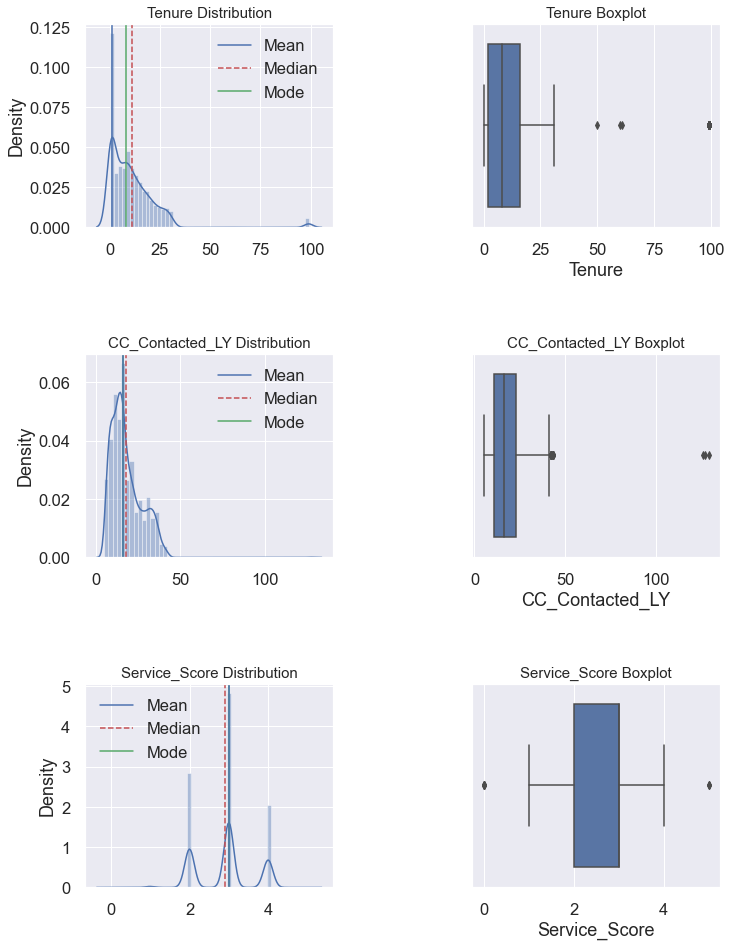

In [249]:
## Univariate analysis for first 3 columns

fig, axes = plt.subplots(nrows=3,ncols=2)
fig.set_size_inches(12, 15)
fig.tight_layout(pad=5.0)

mean=churn_train['Tenure'].mean()
median=churn_train['Tenure'].median()
mode=churn_train['Tenure'].mode().array[0]

a = sns.distplot(churn_train['Tenure'] , axlabel=False, ax=axes[0][0])
a.set_title("Tenure Distribution",fontsize=15)
axes[0][0].axvline(mean, color='r', linestyle='--')
axes[0][0].axvline(median, color='g', linestyle='-')
axes[0][0].axvline(mode, color='b', linestyle='-')
axes[0][0].legend({'Mean':mean,'Median':median,'Mode':mode})

a = sns.boxplot(churn_train['Tenure'], ax=axes[0][1])
a.set_title("Tenure Boxplot",fontsize=15)

mean2=churn_train['CC_Contacted_LY'].mean()
median2=churn_train['CC_Contacted_LY'].median()
mode2=churn_train['CC_Contacted_LY'].mode().array[0]

a = sns.distplot(churn_train['CC_Contacted_LY'] , axlabel=False, ax=axes[1][0])
a.set_title("CC_Contacted_LY Distribution",fontsize=15)
axes[1][0].axvline(mean2, color='r', linestyle='--')
axes[1][0].axvline(median2, color='g', linestyle='-')
axes[1][0].axvline(mode2, color='b', linestyle='-')
axes[1][0].legend({'Mean':mean2,'Median':median2,'Mode':mode2})

a = sns.boxplot(churn_train['CC_Contacted_LY'] ,ax=axes[1][1])
a.set_title("CC_Contacted_LY Boxplot",fontsize=15)

mean3=churn_train['Service_Score'].mean()
median3=churn_train['Service_Score'].median()
mode3=churn_train['Service_Score'].mode().array[0]

a = sns.distplot(churn_train['Service_Score'] , axlabel=False, ax=axes[2][0])
a.set_title("Service_Score Distribution",fontsize=15)
axes[2][0].axvline(mean3, color='r', linestyle='--')
axes[2][0].axvline(median3, color='g', linestyle='-')
axes[2][0].axvline(mode3, color='b', linestyle='-')
axes[2][0].legend({'Mean':mean3,'Median':median3,'Mode':mode3})

a = sns.boxplot(churn_train['Service_Score'] , ax=axes[2][1])
a.set_title("Service_Score Boxplot",fontsize=15)

plt.show()

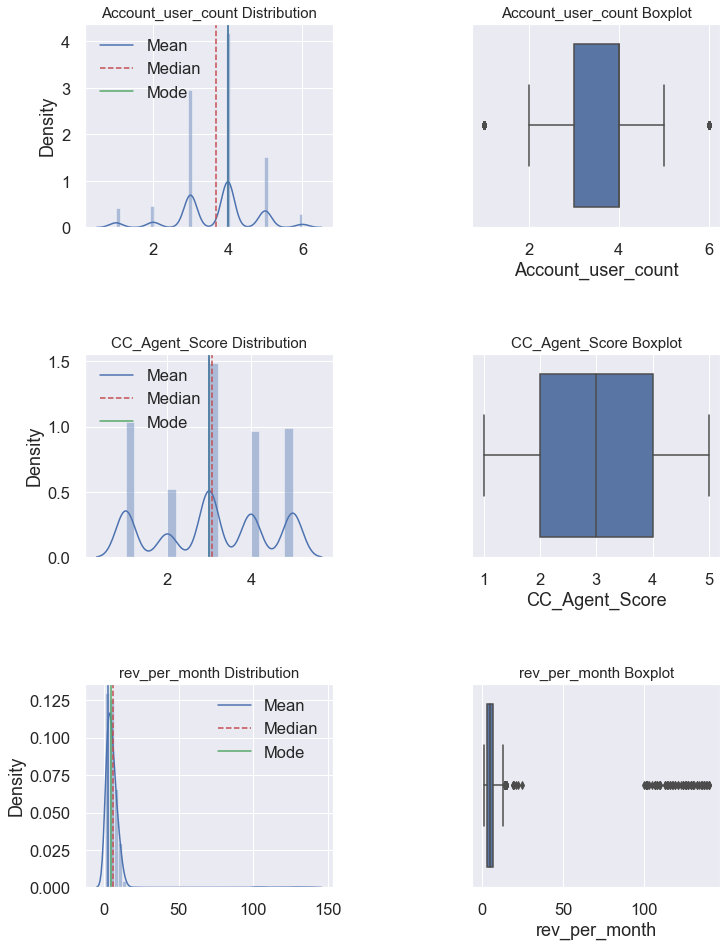

In [250]:
fig, axes = plt.subplots(nrows=3,ncols=2)
fig.set_size_inches(12, 15)
fig.tight_layout(pad=5.0)

mean=churn_train['Account_user_count'].mean()
median=churn_train['Account_user_count'].median()
mode=churn_train['Account_user_count'].mode().array[0]

a = sns.distplot(churn_train['Account_user_count'] , axlabel=False, ax=axes[0][0])
a.set_title("Account_user_count Distribution",fontsize=15)
axes[0][0].axvline(mean, color='r', linestyle='--')
axes[0][0].axvline(median, color='g', linestyle='-')
axes[0][0].axvline(mode, color='b', linestyle='-')
axes[0][0].legend({'Mean':mean,'Median':median,'Mode':mode})

a = sns.boxplot(churn_train['Account_user_count'], ax=axes[0][1])
a.set_title("Account_user_count Boxplot",fontsize=15)

mean1=churn_train['CC_Agent_Score'].mean()
median1=churn_train['CC_Agent_Score'].median()
mode1=churn_train['CC_Agent_Score'].mode().array[0]

a = sns.distplot(churn_train['CC_Agent_Score'] , axlabel=False, ax=axes[1][0])
a.set_title("CC_Agent_Score Distribution",fontsize=15)
axes[1][0].axvline(mean1, color='r', linestyle='--')
axes[1][0].axvline(median1, color='g', linestyle='-')
axes[1][0].axvline(mode1, color='b', linestyle='-')
axes[1][0].legend({'Mean':mean1,'Median':median1,'Mode':mode1})

a = sns.boxplot(churn_train['CC_Agent_Score'] , ax=axes[1][1])
a.set_title("CC_Agent_Score Boxplot",fontsize=15)

mean2=churn_train['rev_per_month'].mean()
median2=churn_train['rev_per_month'].median()
mode2=churn_train['rev_per_month'].mode().array[0]

a = sns.distplot(churn_train['rev_per_month'] , axlabel=False, ax=axes[2][0])
a.set_title("rev_per_month Distribution",fontsize=15)
axes[2][0].axvline(mean2, color='r', linestyle='--')
axes[2][0].axvline(median2, color='g', linestyle='-')
axes[2][0].axvline(mode2, color='b', linestyle='-')
axes[2][0].legend({'Mean':mean2,'Median':median2,'Mode':mode2})

a = sns.boxplot(churn_train['rev_per_month'] , ax=axes[2][1])
a.set_title("rev_per_month Boxplot",fontsize=15)

plt.show()

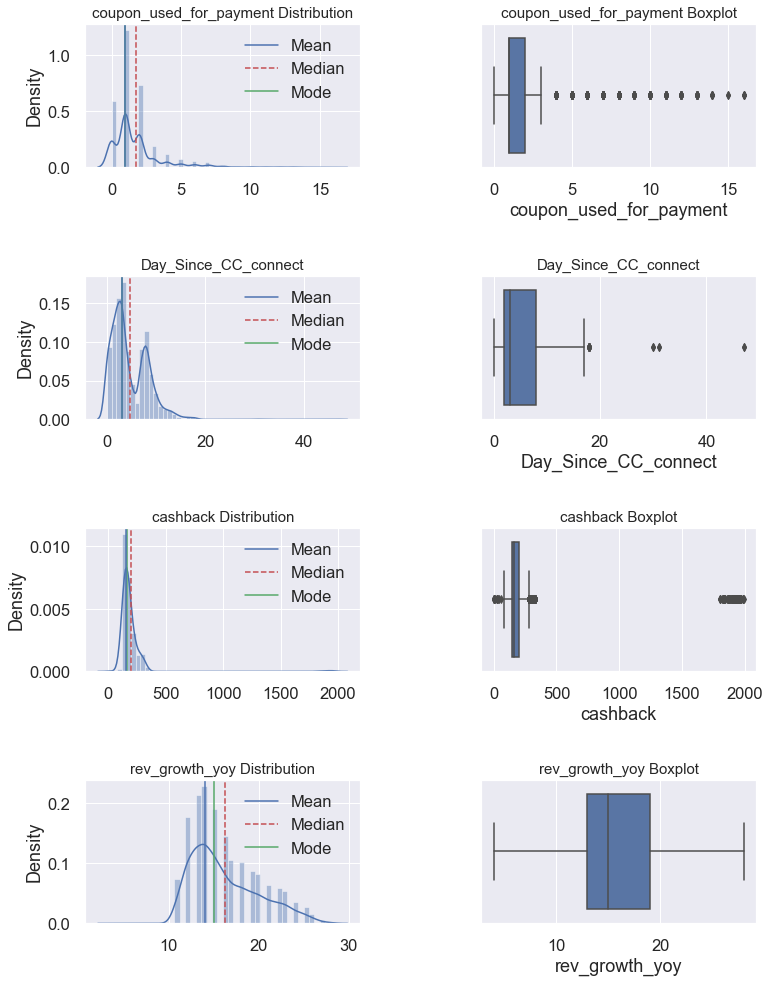

In [251]:
fig, axes = plt.subplots(nrows=4,ncols=2)
fig.set_size_inches(12, 15)
fig.tight_layout(pad=4.0)


mean=churn_train['coupon_used_for_payment'].mean()
median=churn_train['coupon_used_for_payment'].median()
mode=churn_train['coupon_used_for_payment'].mode().array[0]

a = sns.distplot(churn_train['coupon_used_for_payment'] , axlabel=False, ax=axes[0][0])
a.set_title("coupon_used_for_payment Distribution",fontsize=15)
axes[0][0].axvline(mean, color='r', linestyle='--')
axes[0][0].axvline(median, color='g', linestyle='-')
axes[0][0].axvline(mode, color='b', linestyle='-')
axes[0][0].legend({'Mean':mean,'Median':median,'Mode':mode})

a = sns.boxplot(churn_train['coupon_used_for_payment'], ax=axes[0][1])
a.set_title("coupon_used_for_payment Boxplot",fontsize=15)

mean1=churn_train['Day_Since_CC_connect'].mean()
median1=churn_train['Day_Since_CC_connect'].median()
mode1=churn_train['Day_Since_CC_connect'].mode().array[0]

a = sns.distplot(churn_train['Day_Since_CC_connect'] , axlabel=False, ax=axes[1][0])
a.set_title("Day_Since_CC_connect",fontsize=15)
axes[1][0].axvline(mean1, color='r', linestyle='--')
axes[1][0].axvline(median1, color='g', linestyle='-')
axes[1][0].axvline(mode1, color='b', linestyle='-')
axes[1][0].legend({'Mean':mean1,'Median':median1,'Mode':mode1})

a = sns.boxplot(churn_train['Day_Since_CC_connect'] , ax=axes[1][1])
a.set_title("Day_Since_CC_connect",fontsize=15)

mean2=churn_train['cashback'].mean()
median2=churn_train['cashback'].median()
mode2=churn_train['cashback'].mode().array[0]

a = sns.distplot(churn_train['cashback'] , axlabel=False, ax=axes[2][0])
a.set_title("cashback Distribution",fontsize=15)
axes[2][0].axvline(mean2, color='r', linestyle='--')
axes[2][0].axvline(median2, color='g', linestyle='-')
axes[2][0].axvline(mode2, color='b', linestyle='-')
axes[2][0].legend({'Mean':mean2,'Median':median2,'Mode':mode2})

a = sns.boxplot(churn_train['cashback'] , ax=axes[2][1])
a.set_title("cashback Boxplot",fontsize=15)

mean=churn_train['rev_growth_yoy'].mean()
median=churn_train['rev_growth_yoy'].median()
mode=churn_train['rev_growth_yoy'].mode().array[0]

a = sns.distplot(churn_train['rev_growth_yoy'] , axlabel=False, ax=axes[3][0])
a.set_title("rev_growth_yoy Distribution",fontsize=15)
axes[3][0].axvline(mean, color='r', linestyle='--')
axes[3][0].axvline(median, color='g', linestyle='-')
axes[3][0].axvline(mode, color='b', linestyle='-')
axes[3][0].legend({'Mean':mean,'Median':median,'Mode':mode})

a = sns.boxplot(churn_train['rev_growth_yoy'], ax=axes[3][1])
a.set_title("rev_growth_yoy Boxplot",fontsize=15)


plt.show()

In [252]:
from scipy.stats import skew 
churn_train.skew()   # to measure the skeweness of every attribute

AccountID                 -0.008665
Tenure                     3.912858
City_Tier                  0.744004
CC_Contacted_LY            1.414220
Service_Score             -0.003242
Account_user_count        -0.411870
CC_Agent_Score            -0.145050
rev_per_month              9.361251
Complain_ly                0.963152
rev_growth_yoy             0.765604
coupon_used_for_payment    2.617799
Day_Since_CC_connect       1.325511
cashback                   8.798959
Churn                      1.773085
dtype: float64

#### Inference:
The output above shows that the variables ‘rev_per_month’, ‘cashback’, ‘Tenure’ and ‘coupon_used_for_payment’ has a right-skewed distribution with the skewness values of (9.3, 8.9, 3.8, & 2.5 resp.) Ideally, the skewness value should be between -1 and 1. There are many techniques of handling these extreme values, one of which is quantile-based capping or flooring. 

In [253]:
#Tenure to categorical column (Grouping the data according to years.)
def Tenure_lab(churn_train) :
    
    if churn_train["Tenure"] <= 12 :
        return "Tenure_0-12"
    elif (churn_train["Tenure"] > 12) & (churn_train["Tenure"] <= 24 ):
        return "Tenure_12-24"
    elif (churn_train["Tenure"] > 24) & (churn_train["Tenure"] <= 48) :
        return "Tenure_24-48"
    elif (churn_train["Tenure"] > 48) & (churn_train["Tenure"] <= 60) :
        return "Tenure_48-60"
    elif churn_train["Tenure"] > 60 :
        return "Tenure_gt_60"
churn_train["Tenure_group"] = churn_train.apply(lambda churn_train:Tenure_lab(churn_train), axis = 1)

# remove the Tenure variables and check the train data for the 10 rows 

churn_train = churn_train.drop(['Tenure'], axis=1)

#Tenure to categorical column
def Tenure_lab(churn_test) :
    
    if churn_test["Tenure"] <= 12 :
        return "Tenure_0-12"
    elif (churn_test["Tenure"] > 12) & (churn_test["Tenure"] <= 24 ):
        return "Tenure_12-24"
    elif (churn_test["Tenure"] > 24) & (churn_test["Tenure"] <= 48) :
        return "Tenure_24-48"
    elif (churn_test["Tenure"] > 48) & (churn_test["Tenure"] <= 60) :
        return "Tenure_48-60"
    elif churn_test["Tenure"] > 60 :
        return "Tenure_gt_60"
churn_test["Tenure_group"] = churn_test.apply(lambda churn_test:Tenure_lab(churn_test), axis = 1)

# remove the Tenure variables and check the Test data for the 10 rows 

churn_test = churn_test.drop(['Tenure'], axis=1)

churn_train.head(10)

,AccountID,City_Tier,CC_Contacted_LY,Payment,Gender,Service_Score,Account_user_count,account_segment,CC_Agent_Score,Marital_Status,rev_per_month,Complain_ly,rev_growth_yoy,coupon_used_for_payment,Day_Since_CC_connect,cashback,Login_device,Churn,Tenure_group
2095,22095,3.0,34.0,Credit Card,Female,2.0,1.0,Super Plus,1.0,Married,4.0,1.0,18.0,4.0,11.0,233.20,Mobile,0,Tenure_12-24
1875,21875,1.0,6.0,Debit Card,Female,3.0,3.0,HNI,5.0,Married,2.0,0.0,11.0,0.0,7.0,174.12,Mobile,0,Tenure_0-12
9487,29487,3.0,29.0,Credit Card,Male,3.0,6.0,Super,1.0,Married,10.0,1.0,15.0,2.0,3.0,182.40,Mobile,1,Tenure_0-12
5615,25615,1.0,9.0,Debit Card,Male,1.0,5.0,Regular Plus,3.0,Single,4.0,0.0,15.0,1.0,3.0,153.09,Mobile,0,Tenure_12-24
3307,23307,1.0,11.0,Credit Card,Male,3.0,4.0,Super,4.0,Single,11.0,0.0,13.0,2.0,4.0,184.33,Mobile,0,Tenure_12-24
3840,23840,1.0,25.0,Debit Card,Male,3.0,2.0,Super,5.0,Married,3.0,0.0,12.0,1.0,11.0,177.08,Mobile,0,Tenure_0-12
1845,21845,1.0,15.0,Debit Card,Female,3.0,3.0,Super,1.0,Married,2.0,1.0,12.0,1.0,5.0,163.22,Mobile,0,Tenure_0-12
2628,22628,1.0,7.0,Debit Card,Male,2.0,3.0,Regular Plus,1.0,Married,2.0,0.0,11.0,0.0,3.0,120.44,Mobile,0,Tenure_0-12
7249,27249,1.0,12.0,Credit Card,Male,3.0,4.0,Regular Plus,3.0,Single,2.0,0.0,19.0,1.0,0.0,139.30,Mobile,0,Tenure_0-12
11172,31172,1.0,13.0,Credit Card,Male,3.0,4.0,Regular Plus,5.0,Married,6.0,1.0,16.0,3.0,4.0,160.65,Computer,0,Tenure_0-12


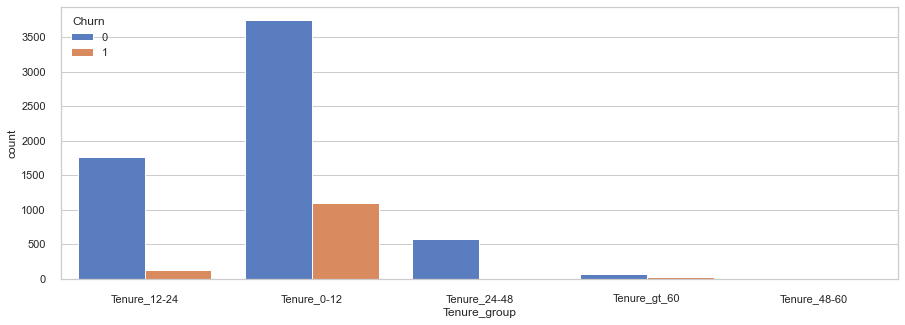

In [254]:
# Churn Vs Tenure
sns.set(style="whitegrid")
sns.set_palette("muted",3)
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.countplot(x='Tenure_group', hue='Churn', data=churn_train)


#### Inference:
    More than 80% of churn customers belongs to Low tenure group(0-12months).

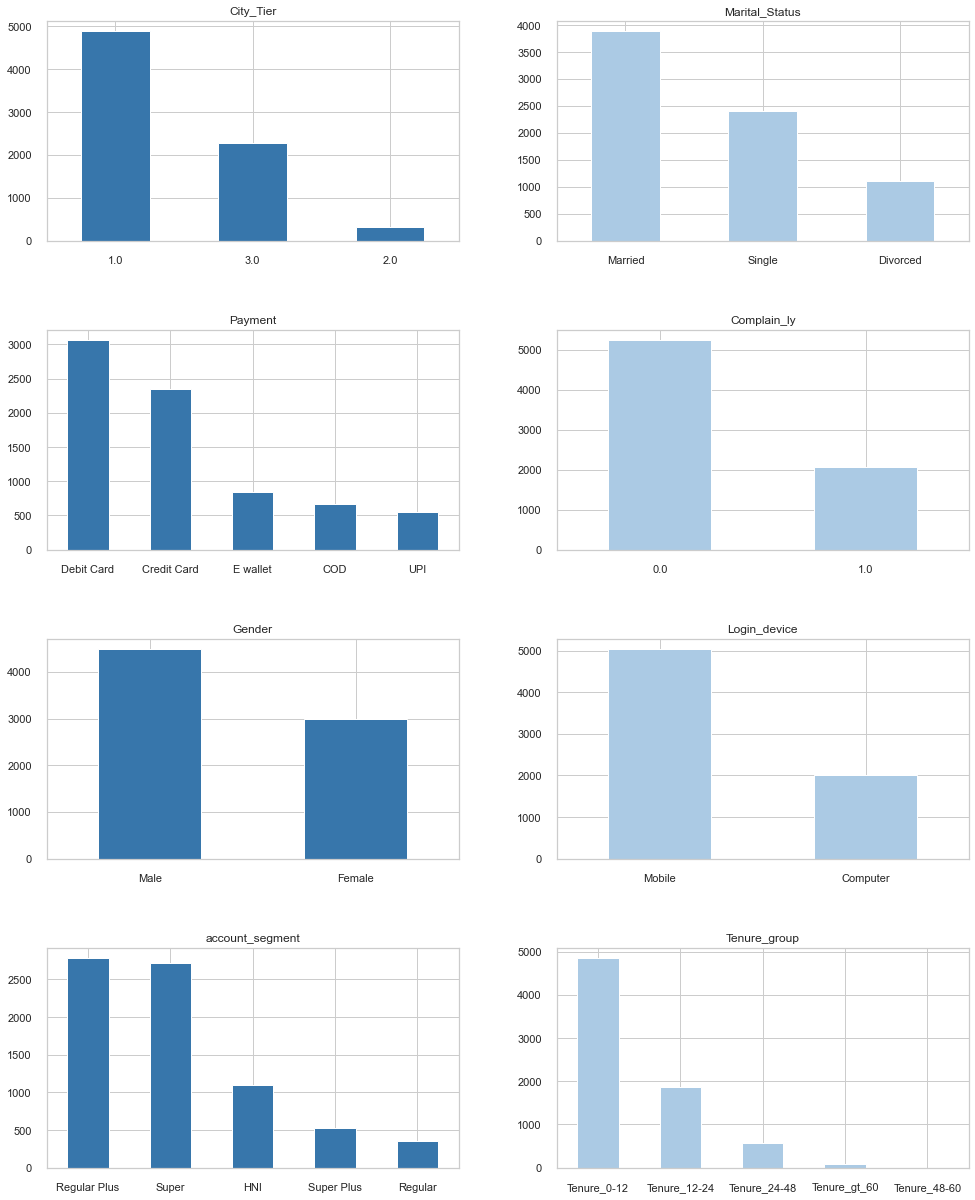

In [255]:
# Distribution of categorical variables:

cat= ['City_Tier','Payment', 'Gender', 'account_segment', 'Marital_Status', 'Complain_ly', 'Login_device','Tenure_group']

fig, axes = plt.subplots(nrows = 4,ncols = 2,
figsize = (15,18))
fig.tight_layout(pad=5.0)

for i, item in enumerate(cat):
    if i < 4:
        ax = churn_train[item].value_counts().plot(
        kind = 'bar',ax=axes[i,0],
        rot = 0, color ='#3776ab' )
        ax.set_title(item)
        
    elif i >=4 and i < 8:
        ax = churn_train[item].value_counts().plot(
        kind = 'bar',ax=axes[i-4,1],
        rot = 0,color ='#abcae4')
        ax.set_title(item)

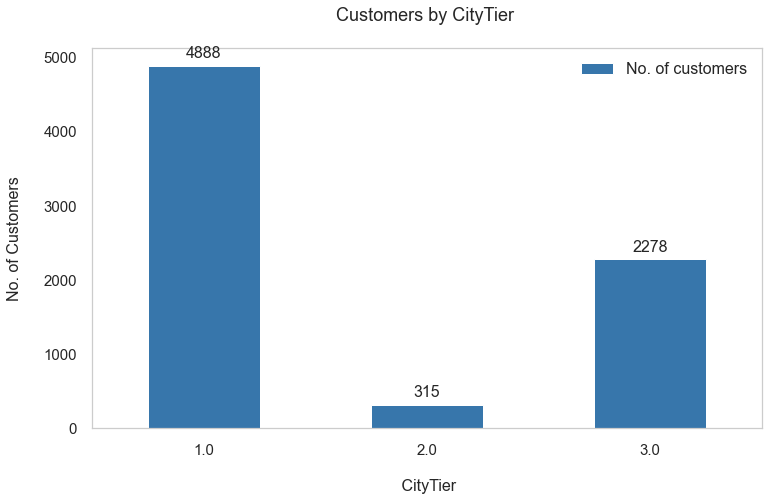

In [256]:
# Distribution of CityTier: 

CityTier = churn_train[[ "AccountID", "City_Tier"]]
Tier = CityTier.groupby ("City_Tier")
CityTier = pd.DataFrame(Tier["AccountID"].count())
CityTier.rename(columns={'AccountID':'No. of customers'}, inplace=True)

ax =  CityTier[["No. of customers"]].plot.bar(title = 'Customers by City Tier',legend =True, table = False, 
grid = False,  subplots = False,figsize =(12, 7), color ='#3776ab', 
fontsize = 15, stacked=False)

plt.ylabel('No. of Customers\n', horizontalalignment="center",
           fontstyle = "normal", fontsize = "16", 
           fontfamily = "sans-serif")

plt.xlabel('\n CityTier',horizontalalignment="center",
           fontstyle = "normal", fontsize = "16", 
           fontfamily = "sans-serif")

plt.title('Customers by CityTier \n',horizontalalignment="center",
          fontstyle = "normal", fontsize = "18", 
          fontfamily = "sans-serif")

plt.legend(loc='best', fontsize = "16")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")

x_labels = np.array(CityTier[["No. of customers"]])

def add_value_labels(ax, spacing=5):   
    for rect in ax.patches:      
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2       
        space = spacing        
        va = 'bottom'      
        if y_value < 0:           
            space *= -1            
            va = 'top'       
        label = "{:.0f}".format(y_value)      
        
        ax.annotate(
            label,                      
            (x_value, y_value),         
            xytext=(0, space),          
            textcoords="offset points",fontsize = "16", 
            ha='center',                
            va=va)  
        
add_value_labels(ax)

#### Inference:
Most of the customers seem to be from City Tier 1. On the other hand, there are a smaller number of customers from City Tier 2.

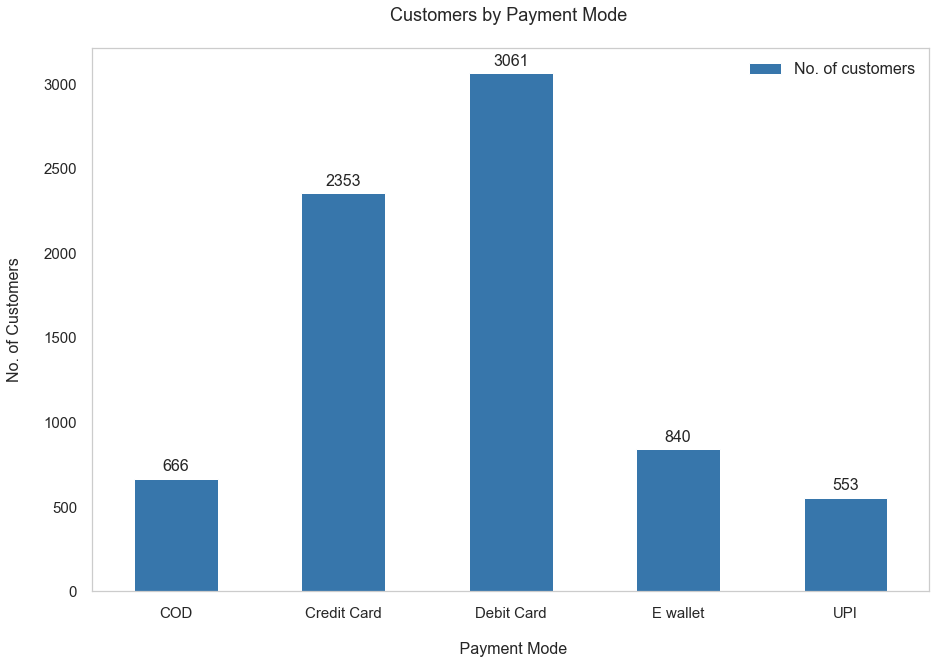

In [257]:
#Distribution of payment method type:

payment_method_mode = churn_train[[  "AccountID", "Payment"]]
mode = payment_method_mode.groupby ("Payment")

payment_method_mode  = pd.DataFrame(mode["AccountID"].count())
payment_method_mode.rename(columns={'AccountID':'No. of customers'}, inplace=True)

ax =  payment_method_mode [["No. of customers"]].plot.bar(title = 'Customers by Payment Mode', 
 legend =True, table = False, grid = False, subplots = False,  figsize =(15, 10),color ='#3776ab', fontsize = 15, stacked=False)

plt.ylabel('No. of Customers\n',horizontalalignment="center",
           fontstyle = "normal", fontsize = "16", 
           fontfamily = "sans-serif")

plt.xlabel('\n Payment Mode',horizontalalignment="center",
           fontstyle = "normal", fontsize = "16", 
           fontfamily = "sans-serif")

plt.title('Customers by Payment Mode \n',horizontalalignment="center", 
          fontstyle = "normal", fontsize = "18", 
          fontfamily = "sans-serif")

plt.legend(loc='best', fontsize = "16")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")

x_labels = np.array(payment_method_mode [["No. of customers"]])

def add_value_labels(ax, spacing=5):   
    for rect in ax.patches:      
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2       
        space = spacing        
        va = 'bottom'      
        if y_value < 0:           
            space *= -1            
            va = 'top'       
        label = "{:.0f}".format(y_value)
     
        ax.annotate(label,
        (x_value, y_value),         
        xytext=(0, space),textcoords="offset points",fontsize = "16", 
        ha='center',va=va)

add_value_labels(ax)

#### Inference:
    Most of the customers prefer debit card and credit card for payments. On the other hand, there are smaller number of customers who pay through E wallet, COD and UPI.

#### Proportion of observations in Target classes

In [258]:
# Get the proportions

churn_train.Churn.value_counts()

0    6274
1    1270
Name: Churn, dtype: int64

#### Checking the proportion of churn

In [259]:
1270/(6274+1270)

0.1683457051961824

#### 16.83% Customers in the total dataset are prone to churn

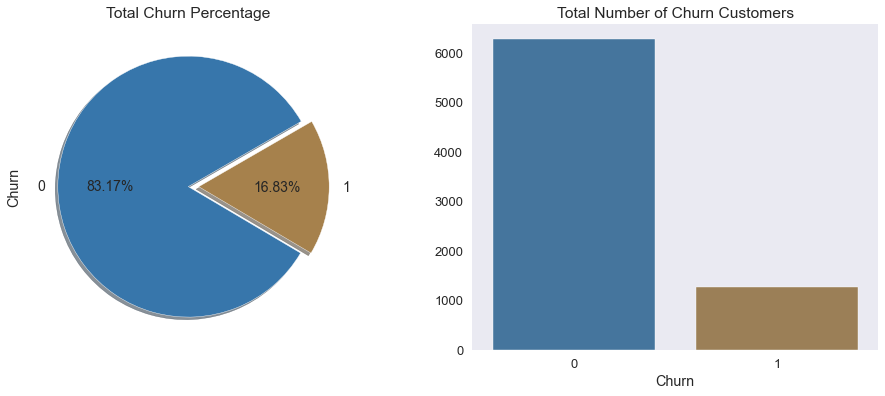

In [260]:
plt.style.use(['seaborn-dark','seaborn-talk'])

fig, ax = plt.subplots(1,2,figsize=(16,6))

churn_train['Churn'].value_counts().plot.pie(explode=[0,0.08], ax=ax[0], autopct='%1.2f%%', shadow=True, 
                                    fontsize=14, startangle=30, colors=["#3776ab", "#a6814c"])
ax[0].set_title('Total Churn Percentage')

sns.countplot('Churn', data=churn_train, ax=ax[1], palette=["#3776ab", "#a6814c"])
ax[1].set_title('Total Number of Churn Customers')
ax[1].set_ylabel(' ')

plt.show()

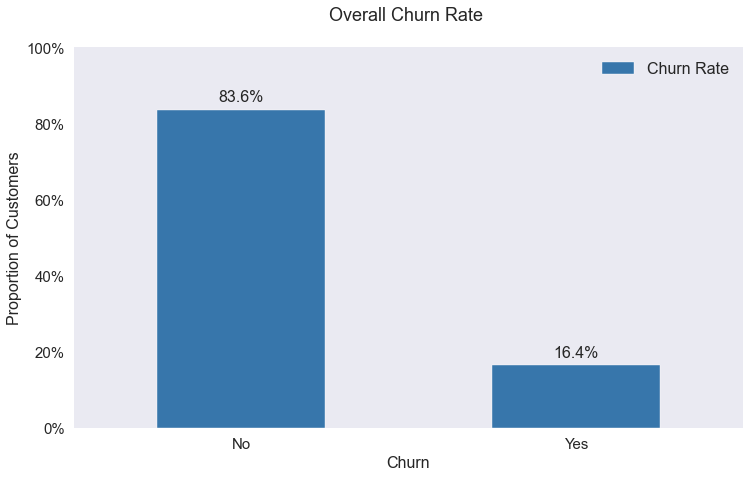

In [261]:
# Overall Churn Rate

import matplotlib.ticker as mtick

churn_rate = churn_train[["Churn", "AccountID"]]
churn_rate ["churn_label"] = pd.Series(

np.where((churn_rate["Churn"] == 0), "No", "Yes"))
labels = churn_rate .groupby ("churn_label")

churn_rate = pd.DataFrame(labels["AccountID"].count())
churn_rate ["Churn Rate"] = (churn_rate ["AccountID"]/ 
                             sum(churn_rate ["AccountID"]) )*100

ax =  churn_rate[["Churn Rate"]].plot.bar(title = 'Overall Churn Rate',
    legend =True, table = False,grid = False,  subplots = False, figsize =(12, 7), 
    color = '#3776ab', fontsize = 15, stacked=False, ylim =(0,100))

plt.ylabel('Proportion of Customers',horizontalalignment="center",
           fontstyle = "normal", fontsize = "16", 
           fontfamily = "sans-serif")

plt.xlabel('Churn',horizontalalignment="center",
           fontstyle = "normal", fontsize = "16", 
           fontfamily = "sans-serif")

plt.title('Overall Churn Rate \n',horizontalalignment="center", 
          fontstyle = "normal", fontsize = "18", 
          fontfamily = "sans-serif")

plt.legend(loc='best', fontsize = "16")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
x_labels = np.array(churn_rate[["AccountID"]])

def add_value_labels(ax, spacing=5):   
    for rect in ax.patches:     
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2       
        space = spacing
        va = 'bottom'        
        if y_value < 0:           
            space *= -1          
            va = 'top'
        label = "{:.1f}%".format(y_value)    
 
        ax.annotate(label,
        (x_value, y_value),         
        xytext=(0, space),fontsize = "16",
        textcoords="offset points", 
        ha='center',va=va)

add_value_labels(ax)

ax.autoscale(enable=False, axis='both', tight=False)

#### Inference:

Overall churn rate: A preliminary look at the overall churn rate shows that around 83.2% of the customers are active. As shown in the chart below, this is an imbalanced classification problem. Machine learning algorithms work well when the number of instances of each class is roughly equal. Since the dataset is skewed, we need to keep that in mind while choosing the metrics for model selection.

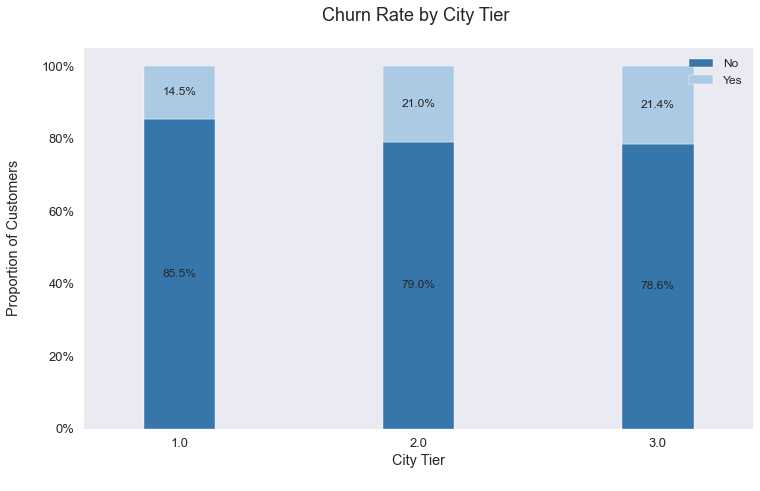

In [262]:
#Churn Rate by City Tier:

import matplotlib.ticker as mtick

CityTier_churn = churn_train.groupby(['City_Tier','Churn']).size().unstack()
CityTier_churn.rename(columns={0:'No', 1:'Yes'}, inplace=True)

colors  = ['#3776ab','#abcae4']

ax = (CityTier_churn.T*100.0 / CityTier_churn.T.sum()).T.plot(kind='bar',width = 0.3,stacked = True,rot = 0,figsize = (12,7),color = colors)

plt.ylabel('Proportion of Customers\n',horizontalalignment="center",
           fontstyle = "normal", fontsize = "large", 
           fontfamily = "sans-serif")

plt.xlabel('City Tier\n',horizontalalignment="center",
           fontstyle = "normal", fontsize = "large", 
           fontfamily = "sans-serif")

plt.title('Churn Rate by City Tier \n',horizontalalignment="center", 
          fontstyle = "normal", fontsize = "18", 
          fontfamily = "sans-serif")

plt.legend(loc='best', fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")

ax.yaxis.set_major_formatter(mtick.PercentFormatter())

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.1f}%'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center')

ax.autoscale(enable=False, axis='both', tight=False)
    

#### Inference:
Customers with a City Tier 3 or rather 2 have a very high probability to churn compared to their peers on Tier 1.

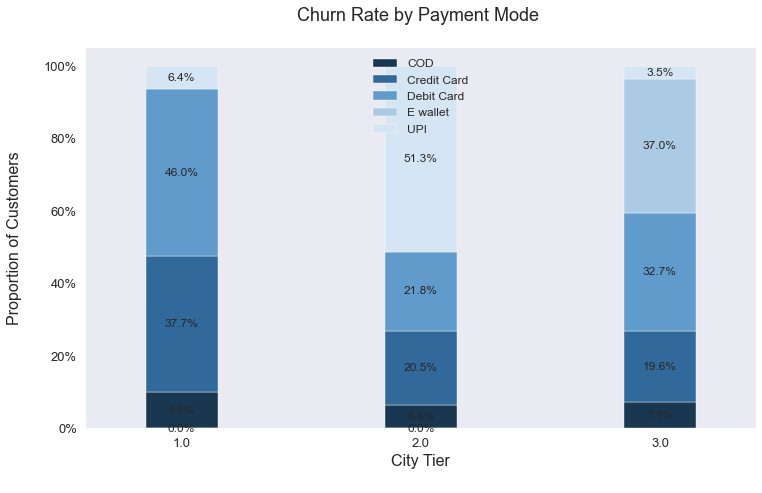

In [263]:
#Churn Rate by Payment Method Type:

import matplotlib.ticker as mtick

CityTier_churn = churn_train.groupby(['City_Tier','Payment']).size().unstack()
CityTier_churn.rename(columns = {0:'No', 1:'Yes'}, inplace=True)
colors  = ['#193750','#316a9a', '#619bcc' , '#abcae4', '#d6e5f4']

ax = (CityTier_churn.T*100.0 / CityTier_churn.T.sum()).T.plot(
kind='bar',width = 0.3,stacked = True,rot = 0,figsize = (12,7),
color = colors)

plt.ylabel('Proportion of Customers\n',horizontalalignment="center",
           fontstyle = "normal", fontsize = "16", 
           fontfamily = "sans-serif")

plt.xlabel('City Tier\n',horizontalalignment="center",
           fontstyle = "normal", fontsize = "16", 
           fontfamily = "sans-serif")

plt.title('Churn Rate by Payment Mode \n',horizontalalignment="center", 
          fontstyle = "normal", fontsize = "18", 
          fontfamily = "sans-serif")

plt.legend(loc='best', fontsize = "12")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")

ax.yaxis.set_major_formatter(mtick.PercentFormatter())

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.1f}%'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center')

ax.autoscale(enable=False, axis='both', tight=False)

#### Inference:
    Customers who pay via Cash On Delivery or Credit Card seem to have the lowest churn rate among all the payment method segments.

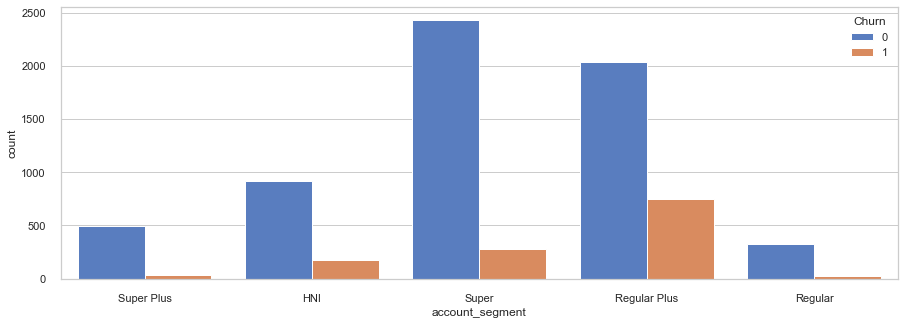

In [264]:
# Account_segment vs Churn Relationship Analysis
sns.set(style="whitegrid")
sns.set_palette("muted",3)
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.countplot(x="account_segment", hue="Churn", data=churn_train)

#### Inferences:

Customers who have account segment of ‘Regular Plus’, ‘Super’ and ‘HNI’ seem to have the highest churn rate among all the other segments.


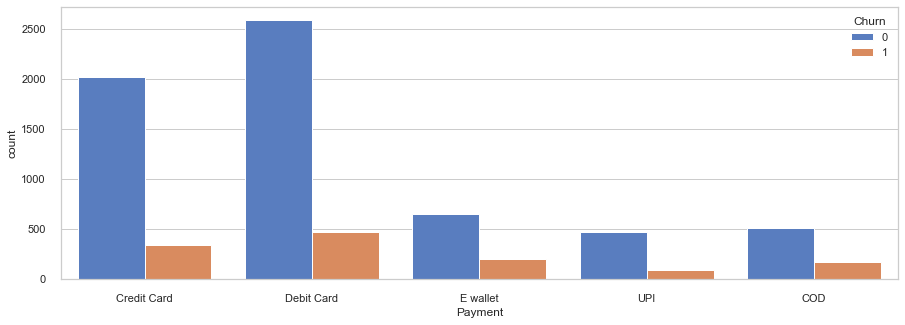

In [265]:
# Payment vs Churn Relationship Analysis
sns.set(style="whitegrid")
sns.set_palette("muted",3)
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.countplot(x="Payment", hue="Churn", data=churn_train)

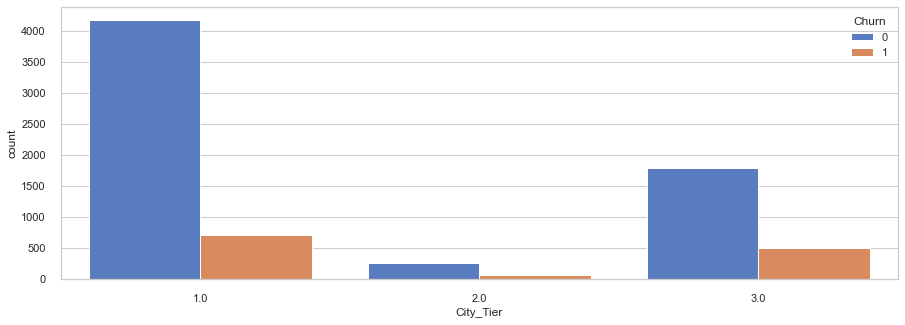

In [266]:
#City Tier vs Churn Relationship Analysis
sns.set(style="whitegrid")
sns.set_palette("muted",3)
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.countplot(x="City_Tier", hue="Churn", data=churn_train)

<AxesSubplot:xlabel='Gender', ylabel='count'>

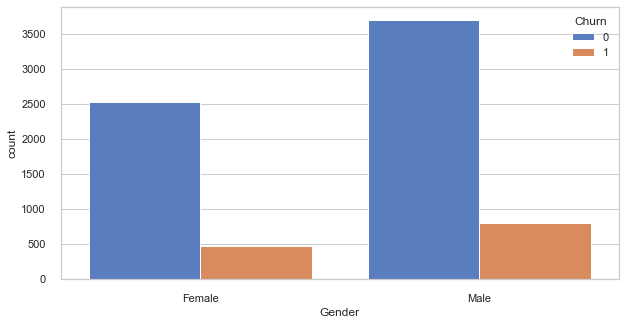

In [267]:
# Gender Vs Churn Relationship Analysis

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size
sns.countplot(x='Gender', hue = 'Churn', data=churn_train)

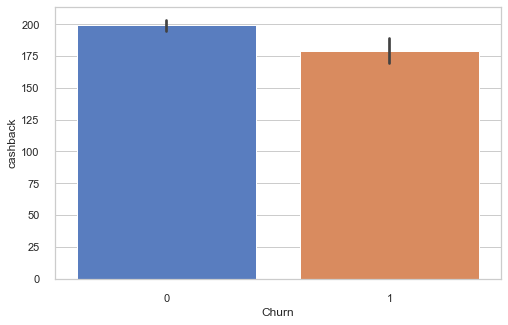

In [268]:
# Churn Vs cashback:
plt.figure(figsize=(8,5))  # setting the figure size
ax = sns.barplot(x='Churn', y='cashback', data=churn_train, palette='muted')  # barplot

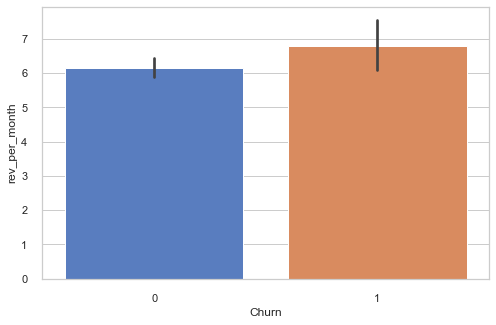

In [269]:
# Churn Vs rev_per_month:
plt.figure(figsize=(8,5))  # setting the figure size
ax = sns.barplot(x='Churn', y='rev_per_month', data=churn_train, palette='muted')  # barplot

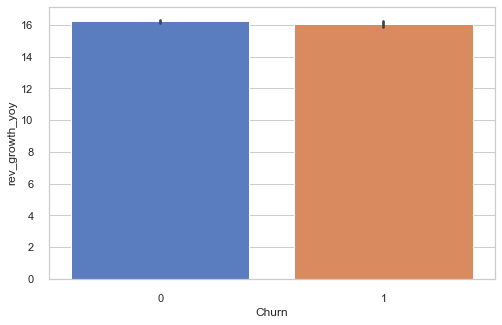

In [270]:
# Churn Vs rev_growth_yoy:
plt.figure(figsize=(8,5))  # setting the figure size
ax = sns.barplot(x='Churn', y='rev_growth_yoy', data=churn_train, palette='muted')  # barplot

#### Inference:
Total revenue generated by both churn and non churn customers are same.

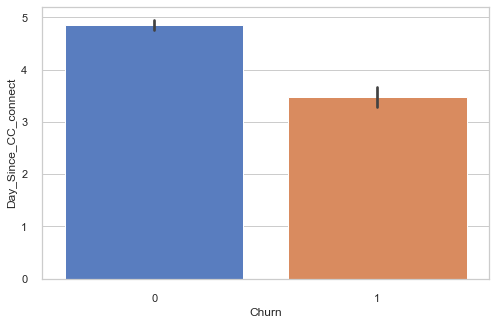

In [271]:
# Churn Vs Day_Since_CC_connect:
plt.figure(figsize=(8,5))  # setting the figure size
ax = sns.barplot(x='Churn', y='Day_Since_CC_connect', data=churn_train, palette='muted')  # barplot

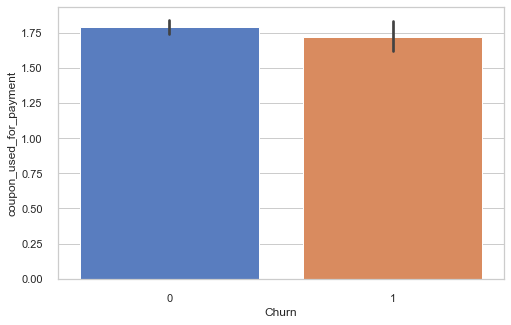

In [272]:
# Churn Vs coupon_used_for_payment:
plt.figure(figsize=(8,5))  # setting the figure size
ax = sns.barplot(x='Churn', y='coupon_used_for_payment', data=churn_train, palette='muted')  # barplot

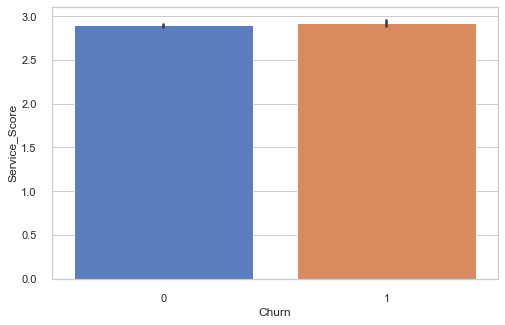

In [273]:
# Churn Vs Service_Score:
plt.figure(figsize=(8,5))  # setting the figure size
ax = sns.barplot(x='Churn', y='Service_Score', data=churn_train, palette='muted')  # barplot

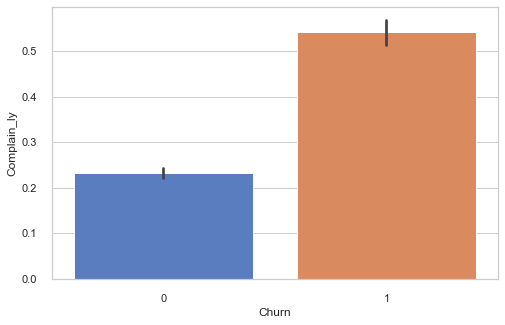

In [274]:
# Churn Vs Complain_ly:
plt.figure(figsize=(8,5))  # setting the figure size
ax = sns.barplot(x='Churn', y='Complain_ly', data=churn_train, palette='muted')  # barplot

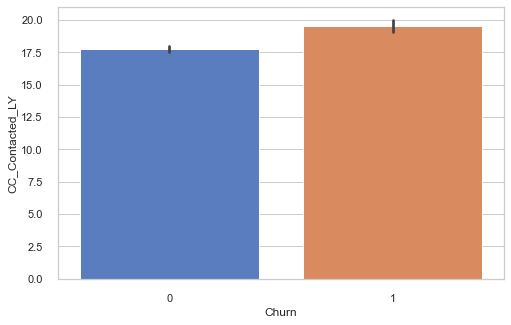

In [275]:
# Churn Vs CC_Contacted_LY:
plt.figure(figsize=(8,5))  # setting the figure size
ax = sns.barplot(x='Churn', y='CC_Contacted_LY', data=churn_train, palette='muted')  # barplot

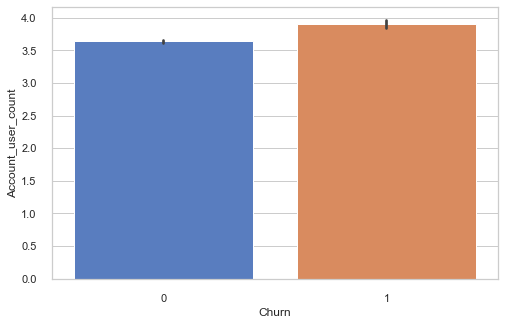

In [276]:
# Churn Vs Account_user_count:
plt.figure(figsize=(8,5))  # setting the figure size
ax = sns.barplot(x='Churn', y='Account_user_count', data=churn_train, palette='muted')  # barplot

#### Inferences:
Churned Customer Profile: 

For better understanding we wanted to compare these important variables from costumers who churned and costumers who did not churned. 

Customer that churned are those who -
- Tend to generate less cashback amounts.
- Contacted the customer care very less recently.
- Have a greater number of complains. 
- Have more account users. 


In [277]:
#Find positive and negative correlations:

correlations = churn_train.corrwith(churn_train.Churn)
correlations = correlations[correlations!=1]

positive_correlations = correlations[
correlations >0].sort_values(ascending = False)

negative_correlations =correlations[
correlations <0].sort_values(ascending = False)

print('Most Positive Correlations:\n', positive_correlations)
print('\nMost Negative Correlations:\n', negative_correlations)

Most Positive Correlations:
 Complain_ly           0.257065
CC_Agent_Score        0.107562
Account_user_count    0.097248
City_Tier             0.085430
CC_Contacted_LY       0.073907
rev_per_month         0.020572
Service_Score         0.011384
dtype: float64

Most Negative Correlations:
 AccountID                 -0.009916
coupon_used_for_payment   -0.013266
rev_growth_yoy            -0.016252
cashback                  -0.042804
Day_Since_CC_connect      -0.139870
dtype: float64


Text(0.5, 1.0, 'Correlation with Churn Rate \n')

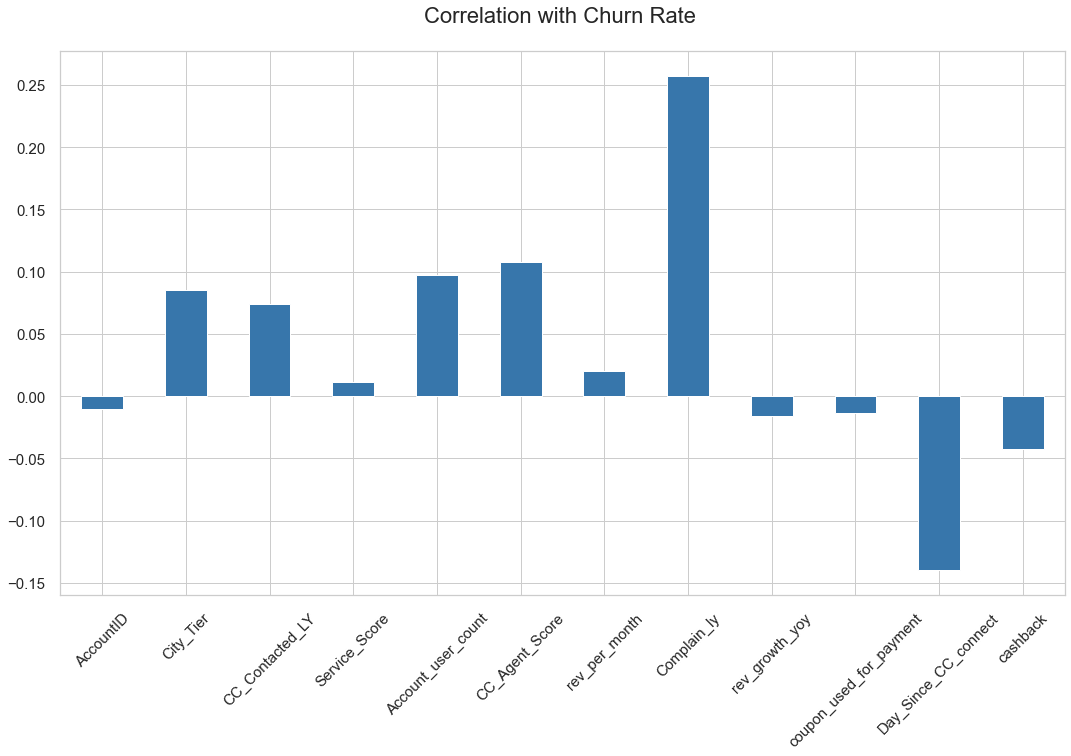

In [278]:
# Plot positive & negative correlations:

correlations = churn_train.corrwith(churn_train.Churn)
correlations = correlations[correlations!=1]

correlations.plot.bar(
        figsize = (18, 10), 
        fontsize = 15, 
        color = '#3776ab',
        rot = 45, grid = True)

plt.title('Correlation with Churn Rate \n', horizontalalignment="center", 
          fontstyle = "normal", fontsize = "22", 
          fontfamily = "sans-serif")


#### Plot Correlation Matrix of all independent variables:
Correlation matrix helps us to discover the bivariate relationship between independent variables in a dataset.

<AxesSubplot:>

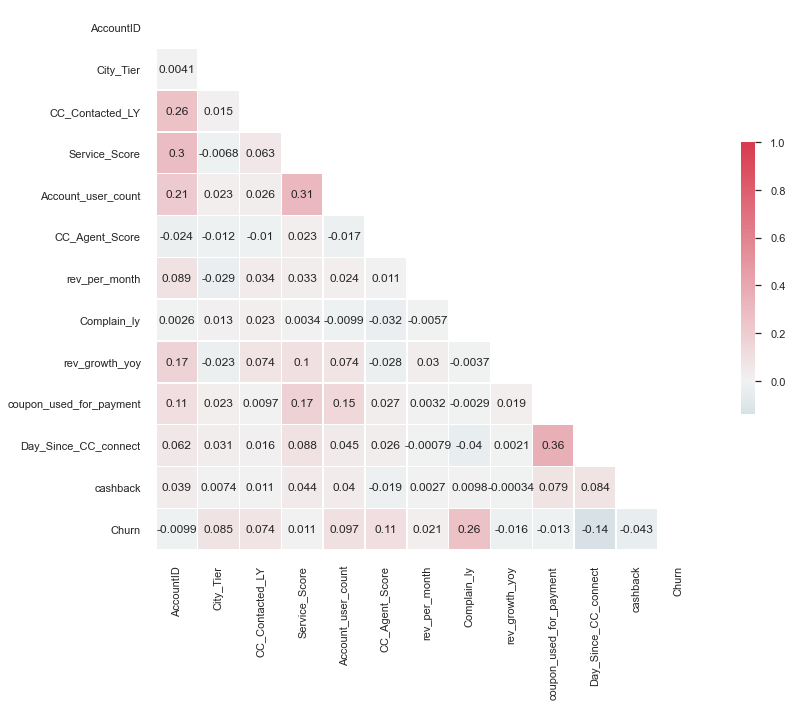

In [279]:
#Set and compute the Correlation Matrix:
sns.set(style="white")
corr = churn_train.corr()

#Generate a mask for the upper triangle:
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

#Set up the matplotlib figure and a diverging colormap:
f, ax = plt.subplots(figsize=(15, 10))
cmap = sns.diverging_palette(220, 8, as_cmap=True)

#Draw the heatmap with the mask and correct aspect ratio:
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5})

In [280]:
# remove the unwanted variables and check the data for the 10 rows 

churn_train = churn_train.drop(['AccountID'], axis=1)
churn_test = churn_test.drop(['AccountID'], axis=1)
churn_train.head(10)

,City_Tier,CC_Contacted_LY,Payment,Gender,Service_Score,Account_user_count,account_segment,CC_Agent_Score,Marital_Status,rev_per_month,Complain_ly,rev_growth_yoy,coupon_used_for_payment,Day_Since_CC_connect,cashback,Login_device,Churn,Tenure_group
2095,3.0,34.0,Credit Card,Female,2.0,1.0,Super Plus,1.0,Married,4.0,1.0,18.0,4.0,11.0,233.20,Mobile,0,Tenure_12-24
1875,1.0,6.0,Debit Card,Female,3.0,3.0,HNI,5.0,Married,2.0,0.0,11.0,0.0,7.0,174.12,Mobile,0,Tenure_0-12
9487,3.0,29.0,Credit Card,Male,3.0,6.0,Super,1.0,Married,10.0,1.0,15.0,2.0,3.0,182.40,Mobile,1,Tenure_0-12
5615,1.0,9.0,Debit Card,Male,1.0,5.0,Regular Plus,3.0,Single,4.0,0.0,15.0,1.0,3.0,153.09,Mobile,0,Tenure_12-24
3307,1.0,11.0,Credit Card,Male,3.0,4.0,Super,4.0,Single,11.0,0.0,13.0,2.0,4.0,184.33,Mobile,0,Tenure_12-24
3840,1.0,25.0,Debit Card,Male,3.0,2.0,Super,5.0,Married,3.0,0.0,12.0,1.0,11.0,177.08,Mobile,0,Tenure_0-12
1845,1.0,15.0,Debit Card,Female,3.0,3.0,Super,1.0,Married,2.0,1.0,12.0,1.0,5.0,163.22,Mobile,0,Tenure_0-12
2628,1.0,7.0,Debit Card,Male,2.0,3.0,Regular Plus,1.0,Married,2.0,0.0,11.0,0.0,3.0,120.44,Mobile,0,Tenure_0-12
7249,1.0,12.0,Credit Card,Male,3.0,4.0,Regular Plus,3.0,Single,2.0,0.0,19.0,1.0,0.0,139.30,Mobile,0,Tenure_0-12
11172,1.0,13.0,Credit Card,Male,3.0,4.0,Regular Plus,5.0,Married,6.0,1.0,16.0,3.0,4.0,160.65,Computer,0,Tenure_0-12


In [281]:
#After removal of unwanted variables
print(churn_train.shape)
print(churn_test.shape)

(7544, 18)
(3716, 18)


#### Checking for duplicate data

In [282]:
#Checking for duplicate data

dups1 = churn_train.duplicated()
print('Number of duplicate rows = %d' % (dups1.sum()))
churn_train[dups1]


Number of duplicate rows = 107


,City_Tier,CC_Contacted_LY,Payment,Gender,Service_Score,Account_user_count,account_segment,CC_Agent_Score,Marital_Status,rev_per_month,Complain_ly,rev_growth_yoy,coupon_used_for_payment,Day_Since_CC_connect,cashback,Login_device,Churn,Tenure_group
1092,1.0,15.0,Credit Card,Male,3.0,1.0,Regular Plus,3.0,Married,2.0,0.0,16.0,0.0,4.0,144.01,Mobile,0,Tenure_0-12
4383,3.0,10.0,Debit Card,Male,4.0,4.0,HNI,3.0,Married,2.0,0.0,13.0,2.0,14.0,231.09,Mobile,0,Tenure_0-12
4763,1.0,9.0,Debit Card,Female,4.0,5.0,Regular Plus,3.0,Single,3.0,0.0,15.0,2.0,1.0,147.74,Mobile,0,Tenure_12-24
2112,1.0,9.0,UPI,Female,2.0,3.0,Super,4.0,Single,4.0,0.0,15.0,1.0,1.0,141.07,Mobile,0,Tenure_0-12
5358,3.0,23.0,Debit Card,Female,3.0,4.0,Super,1.0,Married,3.0,1.0,26.0,1.0,3.0,178.68,Computer,0,Tenure_0-12
2887,1.0,28.0,Credit Card,Female,3.0,4.0,Super,3.0,Married,4.0,0.0,17.0,1.0,3.0,177.65,Computer,0,Tenure_12-24
5230,3.0,14.0,Debit Card,Male,3.0,4.0,Super,5.0,Single,2.0,0.0,15.0,2.0,4.0,173.98,Computer,0,Tenure_0-12
3861,1.0,14.0,Debit Card,Male,4.0,4.0,Regular Plus,5.0,Single,5.0,1.0,15.0,1.0,4.0,146.66,Mobile,1,Tenure_0-12
5552,3.0,14.0,Debit Card,Female,3.0,4.0,Super,1.0,Married,3.0,1.0,12.0,2.0,10.0,177.04,Mobile,0,Tenure_0-12
546,1.0,16.0,Debit Card,Male,2.0,3.0,Regular Plus,4.0,Married,2.0,0.0,14.0,1.0,0.0,120.08,Mobile,0,Tenure_0-12


In [283]:
X_train = churn_train.drop(['Churn'], axis=1)
y_train = churn_train['Churn'] 
X_test = churn_test.drop(['Churn'], axis=1)
y_test = churn_test['Churn']

In [284]:
#Checking for Missing values

def missing_check(X_train):
    total = X_train.isnull().sum().sort_values(ascending=False)   # total number of null values
    percent = (X_train.isnull().sum()/X_train.isnull().count()).sort_values(ascending=False)*100  # percentage of values that are null
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])  # putting the above two together
    return missing_data 

# return the dataframe
missing_check(X_train)


,Total,Percent
rev_per_month,522,6.919406
Login_device,506,6.707317
cashback,312,4.135737
Account_user_count,290,3.844115
Complain_ly,239,3.168081
Day_Since_CC_connect,237,3.141569
Tenure_group,144,1.908802
Marital_Status,138,1.829268
CC_Agent_Score,82,1.086957
Gender,72,0.954401


In [285]:
#Checking for Missing values

def missing_check(X_test):
    total = X_test.isnull().sum().sort_values(ascending=False)   # total number of null values
    percent = (X_test.isnull().sum()/X_test.isnull().count()).sort_values(ascending=False)*100  # percentage of values that are null
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])  # putting the above two together
    return missing_data 

# return the dataframe
missing_check(X_test)


,Total,Percent
rev_per_month,269,7.238967
Login_device,254,6.835307
cashback,161,4.332616
Account_user_count,154,4.144241
Day_Since_CC_connect,121,3.256189
Complain_ly,118,3.175457
Tenure_group,74,1.991389
Marital_Status,74,1.991389
City_Tier,49,1.318622
CC_Contacted_LY,41,1.103337


<AxesSubplot:>

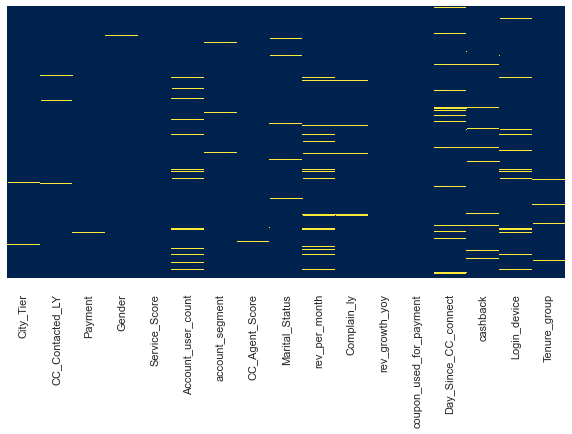

In [286]:
sns.heatmap(X_train.isnull(), yticklabels = False, cbar = False, cmap = 'cividis')

#### Inference
- There are some missing values
- Missing values are common occurrences in data. Unfortunately, most predictive modeling techniques cannot handle any missing values. Therefore, this problem must be addressed prior to modeling.
- Lets treat these categorical variables missing values with mode. 

In [287]:
#Train
for column in X_train[['Payment','Gender','account_segment','Marital_Status','Complain_ly','Login_device','Tenure_group']]:
    X_train[column].fillna(X_train[column].mode()[0], inplace=True)
#Test   
for column in X_test[['Payment','Gender','account_segment','Marital_Status','Complain_ly','Login_device','Tenure_group']]:
    X_test[column].fillna(X_train[column].mode()[0], inplace=True)

In [288]:
#Train
# Converting Object data type into Categorical

for feature in X_train.columns: 
    if X_train[feature].dtype == 'object': 
        print('\n')
        print('feature:',feature)
        print(pd.Categorical(X_train[feature].unique()))
        print(pd.Categorical(X_train[feature].unique()).codes)
        X_train[feature] = pd.Categorical(X_train[feature]).codes
        



feature: Payment
['Credit Card', 'Debit Card', 'E wallet', 'UPI', 'COD']
Categories (5, object): ['COD', 'Credit Card', 'Debit Card', 'E wallet', 'UPI']
[1 2 3 4 0]


feature: Gender
['Female', 'Male']
Categories (2, object): ['Female', 'Male']
[0 1]


feature: account_segment
['Super Plus', 'HNI', 'Super', 'Regular Plus', 'Regular']
Categories (5, object): ['HNI', 'Regular', 'Regular Plus', 'Super', 'Super Plus']
[4 0 3 2 1]


feature: Marital_Status
['Married', 'Single', 'Divorced']
Categories (3, object): ['Divorced', 'Married', 'Single']
[1 2 0]


feature: Login_device
['Mobile', 'Computer']
Categories (2, object): ['Computer', 'Mobile']
[1 0]


feature: Tenure_group
['Tenure_12-24', 'Tenure_0-12', 'Tenure_24-48', 'Tenure_gt_60', 'Tenure_48-60']
Categories (5, object): ['Tenure_0-12', 'Tenure_12-24', 'Tenure_24-48', 'Tenure_48-60', 'Tenure_gt_60']
[1 0 2 4 3]


In [289]:
#Test
# Converting Object data type into Categorical

for feature in X_test.columns: 
    if X_test[feature].dtype == 'object': 
        print('\n')
        print('feature:',feature)
        print(pd.Categorical(X_test[feature].unique()))
        print(pd.Categorical(X_test[feature].unique()).codes)
        X_test[feature] = pd.Categorical(X_test[feature]).codes




feature: Payment
['Credit Card', 'Debit Card', 'COD', 'E wallet', 'UPI']
Categories (5, object): ['COD', 'Credit Card', 'Debit Card', 'E wallet', 'UPI']
[1 2 0 3 4]


feature: Gender
['Female', 'Male']
Categories (2, object): ['Female', 'Male']
[0 1]


feature: account_segment
['Super', 'Regular Plus', 'HNI', 'Super Plus', 'Regular']
Categories (5, object): ['HNI', 'Regular', 'Regular Plus', 'Super', 'Super Plus']
[3 2 0 4 1]


feature: Marital_Status
['Single', 'Married', 'Divorced']
Categories (3, object): ['Divorced', 'Married', 'Single']
[2 1 0]


feature: Login_device
['Mobile', 'Computer']
Categories (2, object): ['Computer', 'Mobile']
[1 0]


feature: Tenure_group
['Tenure_0-12', 'Tenure_12-24', 'Tenure_24-48', 'Tenure_gt_60', 'Tenure_48-60']
Categories (5, object): ['Tenure_0-12', 'Tenure_12-24', 'Tenure_24-48', 'Tenure_48-60', 'Tenure_gt_60']
[0 1 2 4 3]


In [290]:
X_train.head()

,City_Tier,CC_Contacted_LY,Payment,Gender,Service_Score,Account_user_count,account_segment,CC_Agent_Score,Marital_Status,rev_per_month,Complain_ly,rev_growth_yoy,coupon_used_for_payment,Day_Since_CC_connect,cashback,Login_device,Tenure_group
2095,3.0,34.0,1,0,2.0,1.0,4,1.0,1,4.0,1.0,18.0,4.0,11.0,233.20,1,1
1875,1.0,6.0,2,0,3.0,3.0,0,5.0,1,2.0,0.0,11.0,0.0,7.0,174.12,1,0
9487,3.0,29.0,1,1,3.0,6.0,3,1.0,1,10.0,1.0,15.0,2.0,3.0,182.40,1,0
5615,1.0,9.0,2,1,1.0,5.0,2,3.0,2,4.0,0.0,15.0,1.0,3.0,153.09,1,1
3307,1.0,11.0,1,1,3.0,4.0,3,4.0,2,11.0,0.0,13.0,2.0,4.0,184.33,1,1


### KNNImputer: A robust way to impute missing values

k-Nearest Neighbours (kNN) that identifies the neighboring points through a measure of distance and the missing values can be estimated using completed values of neighboring observations.
A new sample is imputed by finding the samples in the training set “closest” to it and averages these nearby points to fill in the value.

In [291]:
col_names = ['City_Tier','CC_Contacted_LY','Payment','Gender','Service_Score','Account_user_count','account_segment',
             'CC_Agent_Score','Marital_Status','rev_per_month','Complain_ly','rev_growth_yoy','coupon_used_for_payment',
             'Day_Since_CC_connect','cashback','Login_device','Tenure_group']    
    
from sklearn.impute import KNNImputer
knn=KNNImputer(n_neighbors=5)

# Fitting the data to the imputer object
imputer = knn.fit(X_train)

# Imputing the train data
X_train = pd.DataFrame(imputer.transform(X_train))
X_train.columns=col_names

# Imputing the median data in test data
X_test = pd.DataFrame(imputer.transform(X_test))
X_test.columns=col_names

X_train.head()

,City_Tier,CC_Contacted_LY,Payment,Gender,Service_Score,Account_user_count,account_segment,CC_Agent_Score,Marital_Status,rev_per_month,Complain_ly,rev_growth_yoy,coupon_used_for_payment,Day_Since_CC_connect,cashback,Login_device,Tenure_group
0,3.0,34.0,1.0,0.0,2.0,1.0,4.0,1.0,1.0,4.0,1.0,18.0,4.0,11.0,233.20,1.0,1.0
1,1.0,6.0,2.0,0.0,3.0,3.0,0.0,5.0,1.0,2.0,0.0,11.0,0.0,7.0,174.12,1.0,0.0
2,3.0,29.0,1.0,1.0,3.0,6.0,3.0,1.0,1.0,10.0,1.0,15.0,2.0,3.0,182.40,1.0,0.0
3,1.0,9.0,2.0,1.0,1.0,5.0,2.0,3.0,2.0,4.0,0.0,15.0,1.0,3.0,153.09,1.0,1.0
4,1.0,11.0,1.0,1.0,3.0,4.0,3.0,4.0,2.0,11.0,0.0,13.0,2.0,4.0,184.33,1.0,1.0


In [292]:
#Checking for Missing values

def missing_check(X_train):
    total = X_train.isnull().sum().sort_values(ascending=False)   # total number of null values
    percent = (X_train.isnull().sum()/X_train.isnull().count()).sort_values(ascending=False)*100  # percentage of values that are null
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])  # putting the above two together
    return missing_data 

# return the dataframe
missing_check(X_train)


,Total,Percent
Tenure_group,0,0.0
CC_Agent_Score,0,0.0
CC_Contacted_LY,0,0.0
Payment,0,0.0
Gender,0,0.0
Service_Score,0,0.0
Account_user_count,0,0.0
account_segment,0,0.0
Marital_Status,0,0.0
Login_device,0,0.0


In [293]:
#Checking for Missing values

def missing_check(X_test):
    total = X_test.isnull().sum().sort_values(ascending=False)   # total number of null values
    percent = (X_test.isnull().sum()/X_test.isnull().count()).sort_values(ascending=False)*100  # percentage of values that are null
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])  # putting the above two together
    return missing_data 

# return the dataframe
missing_check(X_test)


,Total,Percent
Tenure_group,0,0.0
CC_Agent_Score,0,0.0
CC_Contacted_LY,0,0.0
Payment,0,0.0
Gender,0,0.0
Service_Score,0,0.0
Account_user_count,0,0.0
account_segment,0,0.0
Marital_Status,0,0.0
Login_device,0,0.0


#### Checking for outliers (construct box plot for continuous variables)

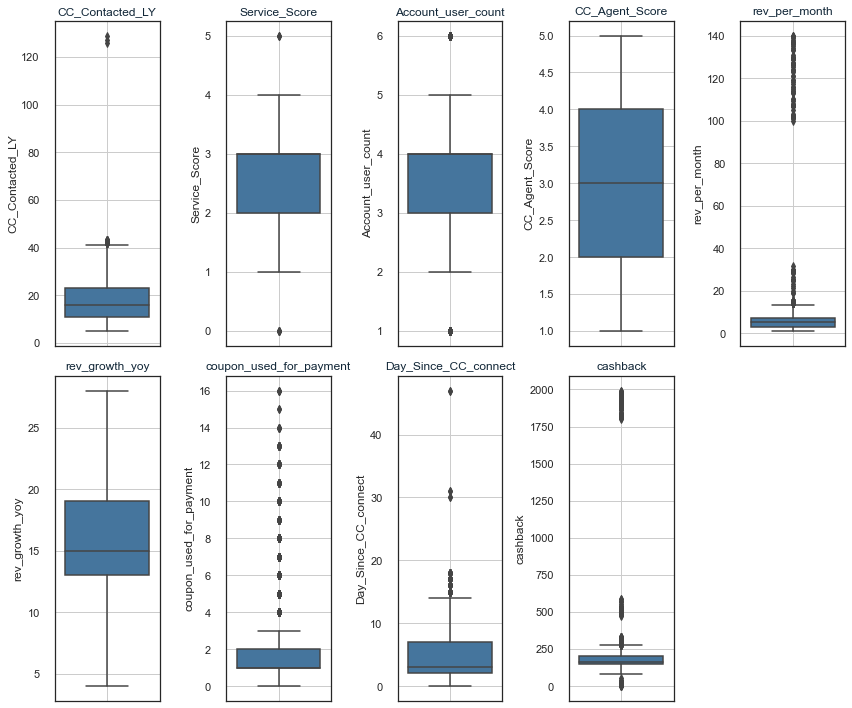

In [294]:
#For Train Data:
continuous = ['CC_Contacted_LY','Service_Score','Account_user_count',
             'CC_Agent_Score','rev_per_month','rev_growth_yoy','coupon_used_for_payment',
             'Day_Since_CC_connect','cashback']    

data_plot=X_train[continuous]

fig=plt.figure(figsize=(12,10))

for i in range(0,len(data_plot.columns)):
    ax=fig.add_subplot(2,5,i+1)
    sns.boxplot(y=data_plot[data_plot.columns[i]],color='#3776ab')
    ax.set_title(data_plot.columns[i],color='#112637')
    plt.grid()

    plt.tight_layout()


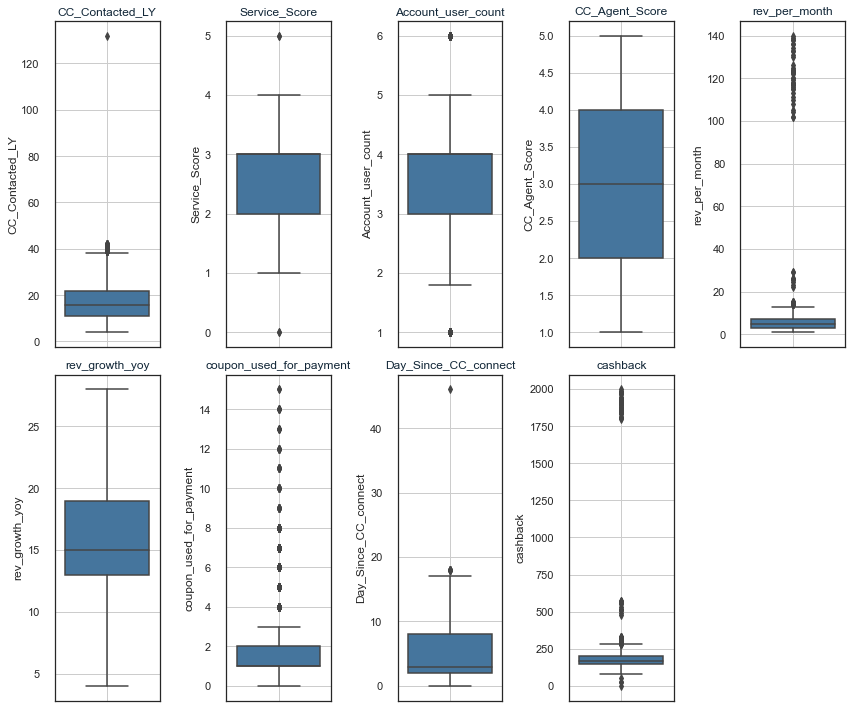

In [295]:
#For Test Data:
data_plot=X_test[continuous]

fig=plt.figure(figsize=(12,10))

for i in range(0,len(data_plot.columns)):
    ax=fig.add_subplot(2,5,i+1)
    sns.boxplot(y=data_plot[data_plot.columns[i]],color='#3776ab')
    ax.set_title(data_plot.columns[i],color='#112637')
    plt.grid()

    plt.tight_layout()

In [296]:
#Capping the outliers

def treat_outlier(x):
    
    # taking 5,25,75 percentile of column
    q5= np.percentile(x,5)
    q25=np.percentile(x,25)
    q75=np.percentile(x,75)
    dt=np.percentile(x,95)
    
    #calculationg IQR range
    IQR=q75-q25
    
    #Calculating minimum threshold
    lower_bound=q25-(1.5*IQR)
    upper_bound=q75+(1.5*IQR)
    
    #Calculating maximum threshold
    print(q5,q25,q75,dt,min,max)
    
    #Capping outliers
    return x.apply(lambda y: dt if y > upper_bound else y).apply(lambda y: q5 if y < lower_bound else y)

In [297]:
for i in X_train:
    X_train[i]=treat_outlier(X_train[i])

1.0 1.0 3.0 3.0 <built-in function min> <built-in function max>
7.0 11.0 23.0 35.0 <built-in function min> <built-in function max>
0.0 1.0 2.0 4.0 <built-in function min> <built-in function max>
0.0 0.0 1.0 1.0 <built-in function min> <built-in function max>
2.0 2.0 3.0 4.0 <built-in function min> <built-in function max>
2.0 3.0 4.0 5.0 <built-in function min> <built-in function max>
0.0 2.0 3.0 4.0 <built-in function min> <built-in function max>
1.0 2.0 4.0 5.0 <built-in function min> <built-in function max>
0.0 1.0 2.0 2.0 <built-in function min> <built-in function max>
2.0 3.0 7.0 11.0 <built-in function min> <built-in function max>
0.0 0.0 1.0 1.0 <built-in function min> <built-in function max>
12.0 13.0 19.0 24.0 <built-in function min> <built-in function max>
0.0 1.0 2.0 6.0 <built-in function min> <built-in function max>
0.0 2.0 7.0 11.0 <built-in function min> <built-in function max>
124.3615 147.07 199.6275 296.87799999999993 <built-in function min> <built-in function max>
0.0

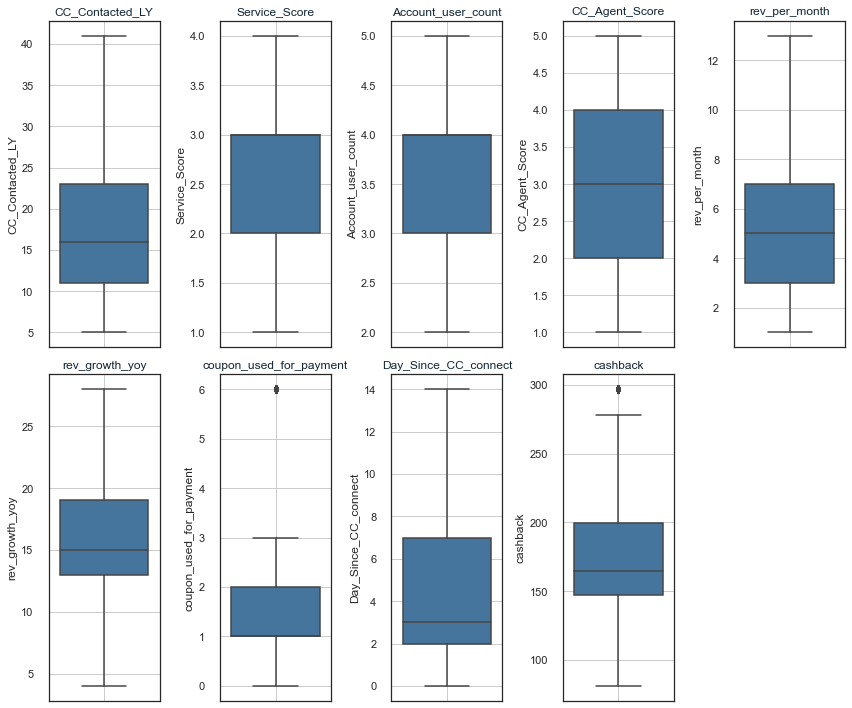

In [298]:
#For Train Data:
data_plot=X_train[continuous]

fig=plt.figure(figsize=(12,10))

for i in range(0,len(data_plot.columns)):
    ax=fig.add_subplot(2,5,i+1)
    sns.boxplot(y=data_plot[data_plot.columns[i]],color='#3776ab')
    ax.set_title(data_plot.columns[i],color='#112637')
    plt.grid()

    plt.tight_layout()


In [299]:
for i in X_train:
    X_test[i]=treat_outlier(X_test[i])

1.0 1.0 3.0 3.0 <built-in function min> <built-in function max>
7.0 11.0 22.0 35.0 <built-in function min> <built-in function max>
0.0 1.0 2.0 4.0 <built-in function min> <built-in function max>
0.0 0.0 1.0 1.0 <built-in function min> <built-in function max>
2.0 2.0 3.0 4.0 <built-in function min> <built-in function max>
2.0 3.0 4.0 5.0 <built-in function min> <built-in function max>
0.0 2.0 3.0 4.0 <built-in function min> <built-in function max>
1.0 2.0 4.0 5.0 <built-in function min> <built-in function max>
0.0 1.0 2.0 2.0 <built-in function min> <built-in function max>
2.0 3.0 7.0 11.0 <built-in function min> <built-in function max>
0.0 0.0 1.0 1.0 <built-in function min> <built-in function max>
11.0 13.0 19.0 23.0 <built-in function min> <built-in function max>
0.0 1.0 2.0 6.0 <built-in function min> <built-in function max>
0.0 2.0 8.0 11.0 <built-in function min> <built-in function max>
124.2025 147.73450000000003 202.0925 297.16499999999996 <built-in function min> <built-in funct

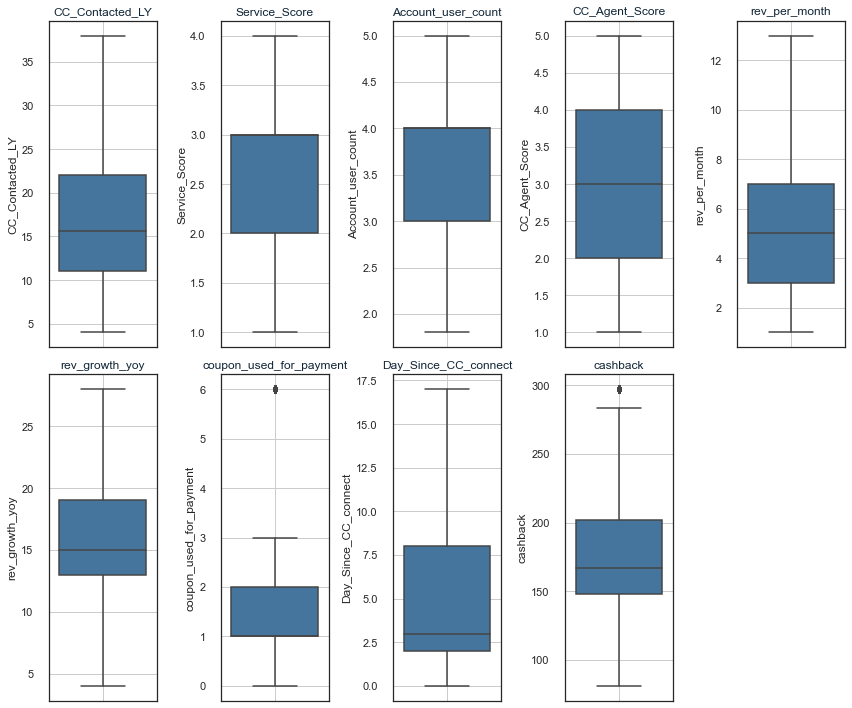

In [300]:
#For Test Data:
data_plot=X_test[continuous]

fig=plt.figure(figsize=(12,10))

for i in range(0,len(data_plot.columns)):
    ax=fig.add_subplot(2,5,i+1)
    sns.boxplot(y=data_plot[data_plot.columns[i]],color='#3776ab')
    ax.set_title(data_plot.columns[i],color='#112637')
    plt.grid()

    plt.tight_layout()

In [301]:
from sklearn.feature_selection import SelectKBest

### Feature Scaling - Standardization:

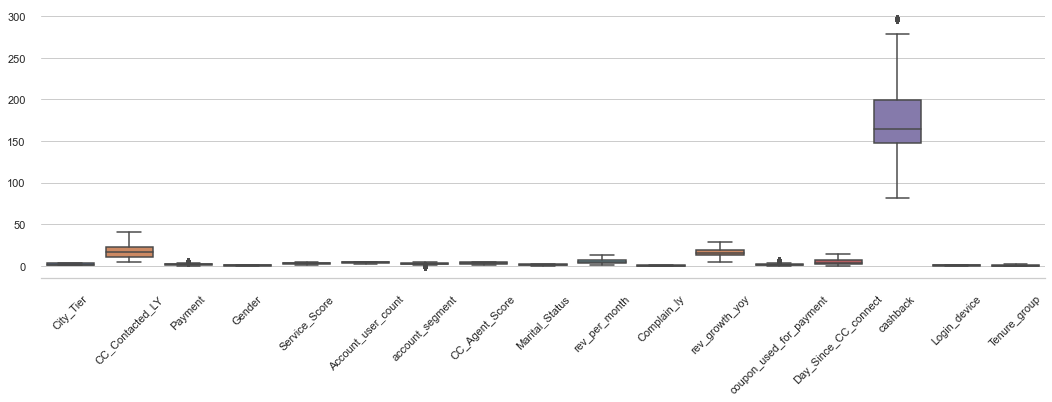

In [302]:
# Before scaling

fig=plt.figure(figsize=(18,5))

sns.set_style("whitegrid")
sns.boxplot(data=X_train,  palette="deep")
plt.xticks(rotation=45)
sns.despine(left=True)

In [303]:
# data standardization with  sklearn
from sklearn.preprocessing import StandardScaler

# copy of datasets
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# numerical features
num_cols = ['CC_Contacted_LY','Service_Score','Account_user_count',
             'CC_Agent_Score','rev_per_month','rev_growth_yoy','coupon_used_for_payment',
             'Day_Since_CC_connect','cashback']

# apply standardization on numerical features
for i in num_cols:
    
    # fit on training data column
    scale = StandardScaler().fit(X_train_scaled[[i]])
    
    # transform the training data column
    X_train_scaled[i] = scale.transform(X_train_scaled[[i]])
    
    # transform the testing data column
    X_test_scaled[i] = scale.transform(X_test_scaled[[i]])

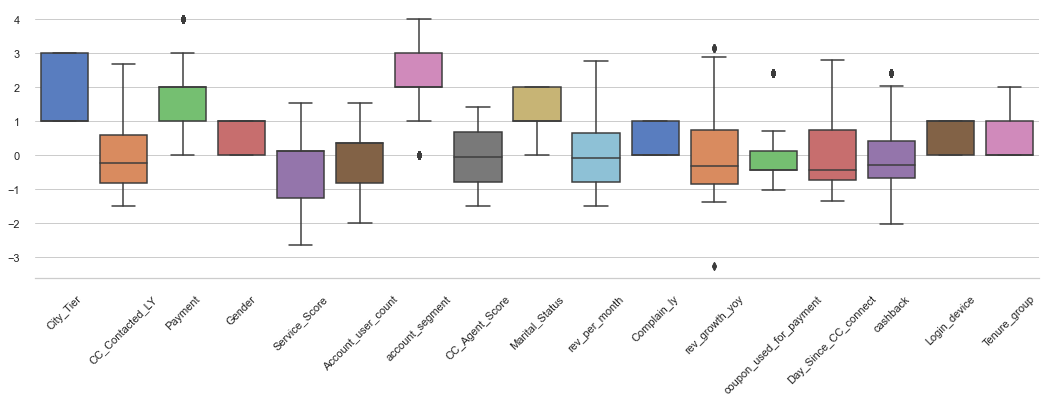

In [304]:
# After scaling

fig=plt.figure(figsize=(18,5))

sns.set_style("whitegrid")
sns.boxplot(data=X_train_scaled, palette="muted")
plt.xticks(rotation=45)
sns.despine(left=True)

#### Before starting model building, lets look at the problem of multicollinearity. Multicollinearity occurs when two or more independent variables are highly correlated with one another in a regression model.

In [305]:
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X_train_scaled):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X_train_scaled.columns
    vif["VIF"] = [variance_inflation_factor(X_train_scaled.values, i) for i in range(X_train_scaled.shape[1])]

    return(vif)

In [306]:
pd.set_option('display.max_rows', None)
print(calc_vif(X_train_scaled[['City_Tier','CC_Contacted_LY','Payment','Gender','Service_Score','Account_user_count',
             'account_segment','CC_Agent_Score','Marital_Status','rev_per_month','Complain_ly','rev_growth_yoy','coupon_used_for_payment',
             'Day_Since_CC_connect','cashback','Login_device','Tenure_group']]).sort_values(by='VIF', ascending = False))

                  variables       VIF
0                 City_Tier  4.217656
6           account_segment  4.070430
2                   Payment  3.973961
8            Marital_Status  3.374655
15             Login_device  3.154050
3                    Gender  2.293952
16             Tenure_group  1.724700
14                 cashback  1.447831
10              Complain_ly  1.355345
13     Day_Since_CC_connect  1.292681
12  coupon_used_for_payment  1.246581
4             Service_Score  1.172210
5        Account_user_count  1.141023
9             rev_per_month  1.092536
11           rev_growth_yoy  1.023296
1           CC_Contacted_LY  1.017668
7            CC_Agent_Score  1.011387


### Feature importance

In [307]:
### Feature Importance

from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt
model_ft = ExtraTreesRegressor()
model_ft.fit(X_train_scaled, y_train)

ExtraTreesRegressor()

In [308]:
print(model_ft.feature_importances_)

[0.05137391 0.06728658 0.0826499  0.05265741 0.03155737 0.04647212
 0.07648739 0.08805345 0.06075566 0.04824104 0.06292647 0.06811528
 0.0310504  0.07902581 0.05032757 0.03973521 0.06328443]


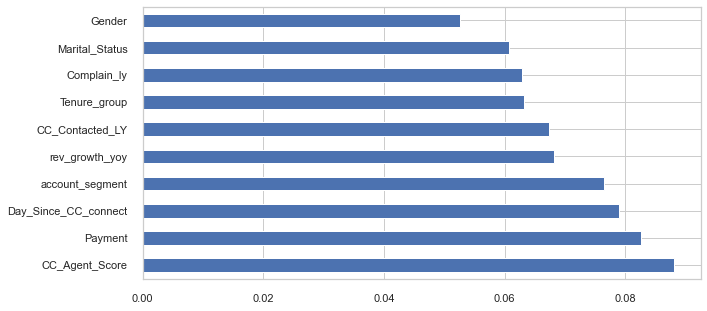

In [309]:
# Plot graph of feature importances for better visualization

feat_importances = pd.Series(model_ft.feature_importances_, index=X_train_scaled.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

#### Inference: 

In [310]:
# copy of datasets
X_train_sc = X_train_scaled.copy()
X_test_sc = X_test_scaled.copy()

### Cluster analysis

### Applying K-Means clustering on scaled data and determining optimum clusters. 

In [311]:
from sklearn.cluster import KMeans 

In [312]:
#Within Sum of Squares (WSS) for 2 to 15 clusters.

wss =[] 
k=range(1,15)
for i in k:
    KM = KMeans(n_clusters=i)
    KM.fit(X_train_sc)
    wss.append(KM.inertia_)

In [313]:
# Within Cluster Sum of Squares
wss

[102448.10732237533,
 92763.53047724682,
 85530.83329356123,
 81116.55509470268,
 77816.02438945526,
 75433.05390994568,
 73194.06045073886,
 71464.6878661013,
 69994.45853935876,
 68571.61988171308,
 67308.42132803086,
 66112.94471154983,
 65091.80374995872,
 64263.275190235996]

### Applying elbow curve and silhouette score.

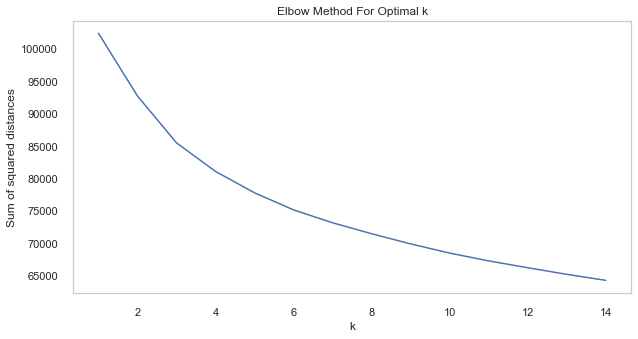

In [76]:
#Plot the Within Sum of Squares (WSS) plot using the values of 'inertia' computed

plt.plot(k, wss,'x-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.grid()
plt.show()

We can observe that the “elbow” is the number 3 which is optimal for this case. Now we can run a K-Means using as n_clusters the number 3

In [77]:
#Create K Means cluster and store the result in the object k_means with k=3
k_means3 = KMeans(n_clusters = 3)

# Fit K means on the scaled_df
k_means3.fit(X_train_sc)
labels_3 = k_means3.labels_

In [78]:
#Let us check the silhouette score and silhouette width for 3 clusters.
silhouette_score(X_train_sc,labels_3)

0.09371343017232191

In [79]:
silhouette_samples(X_train_sc,labels_3).min()

-0.06384347099756602

In [80]:
#Create K Means cluster and store the result in the object k_means with k=3
k_means5 = KMeans(n_clusters = 5)

# Fit K means on the scaled_df
k_means5.fit(X_train_sc)
labels_5 = k_means5.labels_

In [81]:
#Let us check the silhouette score and silhouette width for 5 clusters.
silhouette_score(X_train_sc,labels_5)

0.08014470859061103

In [82]:
silhouette_samples(X_train_sc,labels_5).min()

-0.10536553730526599

In [83]:
#Create K Means cluster and store the result in the object k_means with k=6
k_means6 = KMeans(n_clusters = 6)

# Fit K means on the scaled_df
k_means6.fit(X_train_sc)
labels_6 = k_means6.labels_

In [84]:
#Let us check the silhouette score and silhouette width for 5 clusters.
silhouette_score(X_train_sc,labels_6)

0.08394728184066146

In [85]:
silhouette_samples(X_train_sc,labels_6).min()

-0.08868892343059184

#### Inference:
- WSS reduces as K keeps increasing
- Silhouette score: The average of sil-width for each observation of a dataset is called as silhouette score.
- Silhouette score for 3 Cluster is 0.09 which is more close to +1 than for 5 and 6 cluster(0.080 & 0.083) respectively.
- But selection 2 clusters does not give us any insights so we can say that the 3 Clusters are well separated from each other on an average.
- From 1 and 2 cluster shown in the (WSS) plot, there is a significant drop. Similarly there is a significant drop between 2 and 3. Hence, 3 is a valuable addition in K-means algorithm.

### Hierarchical clustering

#### Creating the Dendrogram

In [86]:
#Importing dendrogram and linkage module
from scipy.cluster.hierarchy import dendrogram, linkage

In [87]:
#Choosing ward linkage method
HClust = linkage(X_train_sc, method = 'ward')

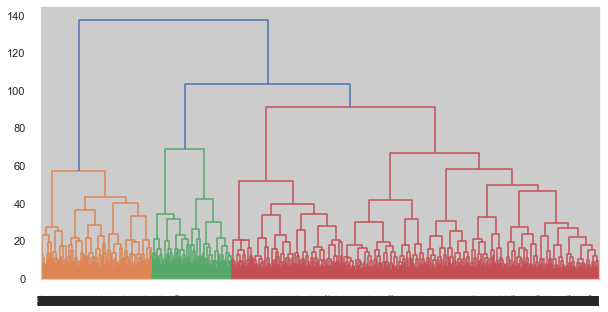

In [88]:
dend = dendrogram(HClust)

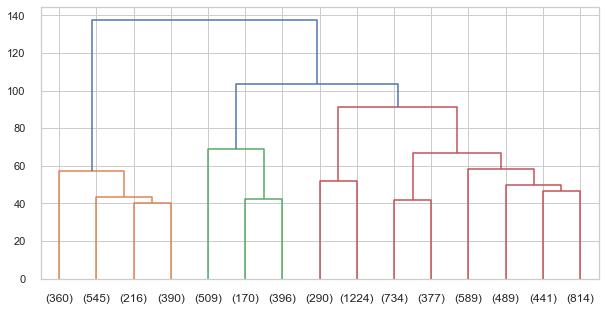

In [89]:
#Plot the truncated dendrogram with the last 15 clusters.
dend = dendrogram(HClust,
                 truncate_mode='lastp',
                 p = 15,# we are looking at the last 15 merges
                 )

In [90]:
from scipy.cluster.hierarchy import fcluster

In [91]:
#Method 1 Maxclust

Hclust_Maxclust = fcluster(HClust, 3, criterion='maxclust')
Hclust_Maxclust

array([2, 1, 3, ..., 3, 3, 3], dtype=int32)

In [92]:
# Method 2 Distance

Hclust_Dist = fcluster(HClust, 5, criterion='distance')
Hclust_Dist

array([304,  90, 591, ..., 466, 914, 434], dtype=int32)

Now, let us go ahead and check whether the number of clusters generated by the 'maxclust' criterion is same as the number of clusters generated by the 'distance' criterion.

In [93]:
np.array_equal(Hclust_Maxclust,Hclust_Dist)

False

In [94]:
X_train_sc['H_clusters'] = Hclust_Maxclust

In [95]:
X_train_sc.head()

,City_Tier,CC_Contacted_LY,Payment,Gender,Service_Score,Account_user_count,account_segment,CC_Agent_Score,Marital_Status,rev_per_month,Complain_ly,rev_growth_yoy,coupon_used_for_payment,Day_Since_CC_connect,cashback,Login_device,Tenure_group,H_clusters
0,3.0,1.858537,1.0,0.0,-1.257156,-1.978338,4.0,-1.502748,1.0,-0.425485,1.0,0.475662,2.404025,1.900627,1.104643,1.0,1.0,2
1,1.0,-1.388082,2.0,0.0,0.134641,-0.813411,0.0,1.402504,1.0,-1.131974,0.0,-1.383554,-1.008455,0.725778,-0.111639,1.0,0.0,1
2,3.0,1.278783,1.0,1.0,0.134641,1.516443,3.0,-1.502748,1.0,1.693980,1.0,-0.321145,0.129039,-0.449071,0.058822,1.0,0.0,3
3,1.0,-1.040230,2.0,1.0,-2.648954,1.516443,2.0,-0.050122,2.0,-0.425485,0.0,-0.321145,-0.439708,-0.449071,-0.544584,1.0,1.0,3
4,1.0,-0.808329,1.0,1.0,0.134641,0.351516,3.0,0.676191,2.0,2.047225,0.0,-0.852350,0.129039,-0.155359,0.098555,1.0,1.0,3


In [96]:
#Cluster Frequency
X_train_sc.H_clusters.value_counts().sort_index()

1    1511
2    1075
3    4958
Name: H_clusters, dtype: int64

In [97]:
#Export the dataframe thus created with the clusters into a csv file.
X_train_sc.to_csv('H_Cluster.csv')

In [98]:
# Cluster Profiles

aggdata1=X_train_sc[['City_Tier','Payment','Gender','account_segment','Marital_Status','Complain_ly','Login_device','Tenure_group','H_clusters']].groupby('H_clusters').agg(pd.Series.mode)
aggdata1['Freq']=X_train_sc.H_clusters.value_counts().sort_index()

In [99]:
aggdata2=X_train_sc[['CC_Contacted_LY','Service_Score','Account_user_count','CC_Agent_Score','rev_per_month','rev_growth_yoy','coupon_used_for_payment','Day_Since_CC_connect','cashback','H_clusters']].groupby('H_clusters').agg(pd.Series.mean)
aggdata2['Freq']=X_train_sc.H_clusters.value_counts().sort_index()

In [100]:
aggdata1

,City_Tier,Payment,Gender,account_segment,Marital_Status,Complain_ly,Login_device,Tenure_group,Freq
H_clusters,,,,,,,,,
1,1.0,2.0,1.0,0.0,1.0,0.0,1.0,0.0,1511
2,1.0,2.0,1.0,4.0,1.0,0.0,1.0,0.0,1075
3,1.0,2.0,1.0,2.0,1.0,0.0,1.0,0.0,4958


In [101]:
aggdata2

,CC_Contacted_LY,Service_Score,Account_user_count,CC_Agent_Score,rev_per_month,rev_growth_yoy,coupon_used_for_payment,Day_Since_CC_connect,cashback,Freq
H_clusters,,,,,,,,,,
1,-0.023501,0.021897,0.075357,0.011406,0.098887,-0.047633,0.311218,0.458152,1.153505,1511
2,0.151915,-0.056197,-0.036648,0.005416,0.060645,0.170034,1.204737,0.741133,0.718223,1075
3,-0.025776,0.005511,-0.015020,-0.004650,-0.043286,-0.022350,-0.356059,-0.300320,-0.507268,4958


In [102]:
Finalagg = pd.concat([aggdata1,aggdata2], axis=1)
Finalagg   

,City_Tier,Payment,Gender,account_segment,Marital_Status,Complain_ly,Login_device,Tenure_group,Freq,CC_Contacted_LY,Service_Score,Account_user_count,CC_Agent_Score,rev_per_month,rev_growth_yoy,coupon_used_for_payment,Day_Since_CC_connect,cashback,Freq
H_clusters,,,,,,,,,,,,,,,,,,,
1,1.0,2.0,1.0,0.0,1.0,0.0,1.0,0.0,1511,-0.023501,0.021897,0.075357,0.011406,0.098887,-0.047633,0.311218,0.458152,1.153505,1511
2,1.0,2.0,1.0,4.0,1.0,0.0,1.0,0.0,1075,0.151915,-0.056197,-0.036648,0.005416,0.060645,0.170034,1.204737,0.741133,0.718223,1075
3,1.0,2.0,1.0,2.0,1.0,0.0,1.0,0.0,4958,-0.025776,0.005511,-0.015020,-0.004650,-0.043286,-0.022350,-0.356059,-0.300320,-0.507268,4958


#### Inference:
- Cluster 1: Customers that have HNI account segment and are in low tenure group are those who spend more for short period.
- Cluster 2: Customers that have Super Plus account segment and are in low tenure group are those who spend little more than medium for less period.
- Cluster 3: Customers that have Regular Plus account segment and are in low tenure group are those who want to try the scheme.


### 1) Model Building - Imbalanced data

#### True Positive (TP): 
- The actual value was positive and the model predicted a positive value

#### True Negative (TN): 
- The actual value was negative and the model predicted a negative value

#### False Positive (FP):
- Type 1 error: The actual value was negative but the model predicted a positive value

#### False Negative (FN):
- Type 2 error: The actual value was positive but the model predicted a negative value

#### Precision: TP/(TP + FP)
- This metric evaluates how precise a model is in predicting positive labels. It answers the question, out of the number of times a model predicted positive, how often was it correct?
- When a positive value is predicted, how often is the prediction correct?

#### Recall: TP/(TP + FN)
- Often called sensitivity, the recall calculates the percentage of actual positives a model correctly identified (True Positive).
- When the actual value is positive, how often is the prediction correct?

#### F1-Score: (2 x Precision x Recall) / (Precision + Recall)

- F1-Score is the weighted average of Precision and Recall used in all types of classification algorithms. Therefore, this score takes both false positives and false negatives into account. F1-Score is usually more useful than accuracy, especially if you have an uneven class distribution.

#### Accuracy: TP+TN/(TP + TN + FP + FN)
- Accuracy is an evaluation metric that allows you to measure the total number of predictions a model gets right. 


### a. Build various models (You can choose to build models for either or all of descriptive, predictive or prescriptive purposes)

In [314]:
# copy of datasets
X_train_sc = X_train_scaled.copy()
X_test_sc = X_test_scaled.copy()

In [315]:
model = list()
dataset = list()
resample = list()
precision = list()
recall = list()
F1score = list()
Accuracy = list()
AUCROC = list()

In [316]:
sns.set(font_scale=1.5)
def train_eval(clf_model, X_train_sc, y_train, algo=None, sampling=None):
    
    # Train set prediction
    y_prob=clf_model.predict_proba(X_train_sc)
    y_pred=clf_model.predict(X_train_sc)
    
    print('Classification Report for Train dataset')
    print('='*60)
    print(classification_report(y_train,y_pred),"\n")
    print('AUC-ROC')
    print('='*60)
    print(roc_auc_score(y_train, y_prob[:,1]),"\n")
    
    print('Confusion Matrix')
    print('='*60)
    cf_matrix = confusion_matrix(y_train, y_pred)
    group_names = ['TN','FP','FN','TP']
    group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    
    
    model.append(algo)
    precision.append(precision_score(y_train,y_pred))
    recall.append(recall_score(y_train,y_pred))
    F1score.append(f1_score(y_train,y_pred))
    Accuracy.append(accuracy_score(y_train, y_pred))
    AUCROC.append(roc_auc_score(y_train, y_prob[:,1]))
    dataset.append('train')
    resample.append(sampling)
   

### b. Test your predictive model against the test set using various appropriate performance metrics

In [317]:
def test_eval(clf_model, X_test_sc, y_test, algo=None,sampling=None):
    
    # Test set prediction
    y_prob=clf_model.predict_proba(X_test_sc)
    y_pred=clf_model.predict(X_test_sc)
    
    print('Classification Report for Test dataset')
    print('='*60)
    print(classification_report(y_test,y_pred),"\n")
    print('AUC-ROC')
    print('='*60)
    print(roc_auc_score(y_test, y_prob[:,1]),"\n")
    
    print('Confusion Matrix')
    print('='*60)
    cf_matrix = confusion_matrix(y_test, y_pred)
    group_names = ['TN','FP','FN','TP']
    group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
          
    model.append(algo)
    precision.append(precision_score(y_test,y_pred))
    recall.append(recall_score(y_test,y_pred))
    F1score.append(f1_score(y_test,y_pred))
    Accuracy.append(accuracy_score(y_test, y_pred))
    AUCROC.append(roc_auc_score(y_test, y_prob[:,1]))
    dataset.append('test')
    resample.append(sampling)

### Model-1: Logistic Regression

#### Definition: 

Logistic regression is a machine learning algorithm for classification. In this algorithm, the probabilities describing the possible outcomes of a single trial are modelled using a logistic function.

#### Advantages: 

Logistic regression is designed for this purpose (classification), and is most useful for understanding the influence of several independent variables on a single outcome variable.
Disadvantages: Works only when the predicted variable is binary, assumes all predictors are independent of each other and assumes data is free of missing values.


In [318]:
from sklearn.linear_model import LogisticRegression

### 1. Original Unsampled Data

In [319]:
log_model=LogisticRegression()

params={'C':np.logspace(1,10),'class_weight':[None,'balanced'],'penalty':['l1','l2']}

cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

# Create random search using 5-fold stratified kfold cross validation
clf_LR = RandomizedSearchCV(log_model, params, cv=cv, scoring='recall', n_jobs=-1)
clf_LR.fit(X_train_sc, y_train)
clf_LR.best_estimator_

LogisticRegression(C=126.48552168552958, class_weight='balanced')

Classification Report for Train dataset
              precision    recall  f1-score   support

           0       0.94      0.73      0.82      6274
           1       0.37      0.77      0.50      1270

    accuracy                           0.74      7544
   macro avg       0.65      0.75      0.66      7544
weighted avg       0.84      0.74      0.77      7544
 

AUC-ROC
0.824815323331635 

Confusion Matrix


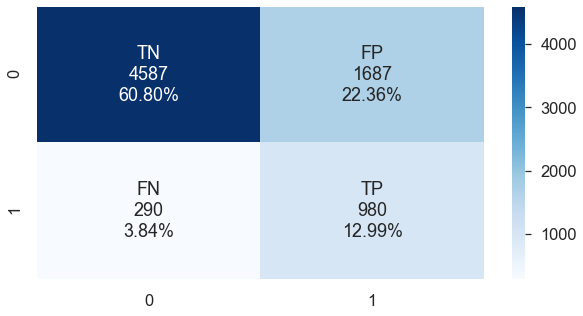

In [320]:
#Train:
train_eval(clf_LR, X_train_sc, y_train, 'Logistic Regression', 'actual')

Classification Report for Test dataset
              precision    recall  f1-score   support

           0       0.94      0.75      0.84      3090
           1       0.39      0.78      0.52       626

    accuracy                           0.75      3716
   macro avg       0.67      0.77      0.68      3716
weighted avg       0.85      0.75      0.78      3716
 

AUC-ROC
0.8400565567583774 

Confusion Matrix


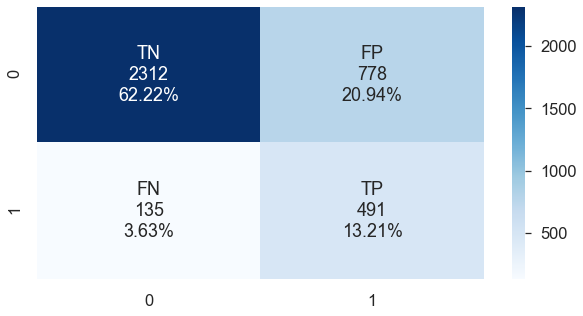

In [321]:
#Test:
test_eval(clf_LR, X_test_sc, y_test, 'Logistic Regression', 'actual')

In [322]:
y_pred = clf_LR.predict(X_train_sc)
Accuracy_Train =  accuracy_score(y_train, y_pred)
print ('Accuracy_Train', Accuracy_Train)

y_pred = clf_LR.predict(X_test_sc)
Accuracy_Test =  accuracy_score(y_test, y_pred)
print ('Accuracy_Test', Accuracy_Test)


Accuracy_Train 0.7379374337221634
Accuracy_Test 0.7543057050592035


### Model-2: Naïve Bayes

Definition: Naive Bayes algorithm based on Bayes’ theorem with the assumption of independence between every pair of features. Naive Bayes classifiers work well in many real-world situations such as document classification and spam filtering.

#### Advantages: 
- This algorithm requires a small amount of training data to estimate the necessary parameters. Naive Bayes classifiers are extremely fast compared to more sophisticated methods.

#### Disadvantages: 
- Naive Bayes is is known to be a bad estimator.


### 1. Original Unsampled Data

In [323]:
# copy of datasets
X_train_sc = X_train_scaled.copy()
X_test_sc = X_test_scaled.copy()

In [324]:
from sklearn.naive_bayes import GaussianNB

clf_nb=GaussianNB()
clf_nb.fit(X_train_sc, y_train)

GaussianNB()

Classification Report for Train dataset
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      6274
           1       0.53      0.53      0.53      1270

    accuracy                           0.84      7544
   macro avg       0.72      0.72      0.72      7544
weighted avg       0.84      0.84      0.84      7544
 

AUC-ROC
0.7973422373048125 

Confusion Matrix


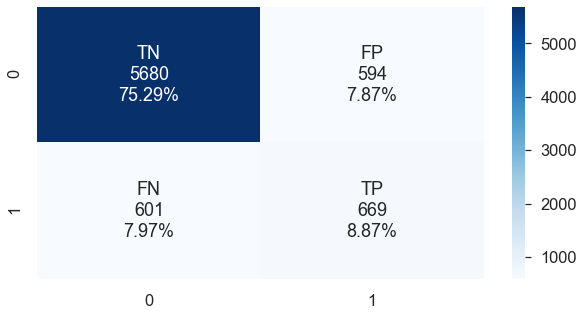

In [325]:
#Train:

train_eval(clf_nb, X_train_sc, y_train, 'Naive Bayes', 'actual')

Classification Report for Test dataset
              precision    recall  f1-score   support

           0       0.90      0.91      0.91      3090
           1       0.54      0.52      0.53       626

    accuracy                           0.84      3716
   macro avg       0.72      0.71      0.72      3716
weighted avg       0.84      0.84      0.84      3716
 

AUC-ROC
0.8075157418034058 

Confusion Matrix


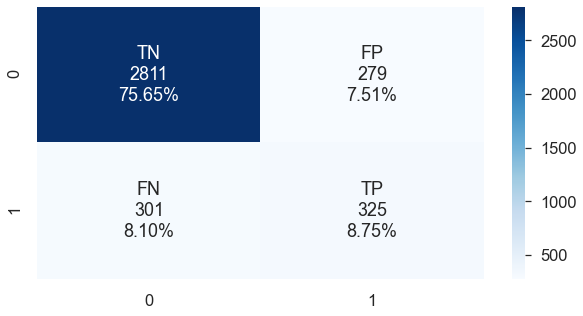

In [326]:
#Test:

test_eval(clf_nb, X_test_sc, y_test, 'Naive Bayes', 'actual')

In [327]:
y_pred = clf_nb.predict(X_train_sc)
Accuracy_Train =  accuracy_score(y_train, y_pred)
print ('Accuracy_Train', Accuracy_Train)

y_pred = clf_nb.predict(X_test_sc)
Accuracy_Test =  accuracy_score(y_test, y_pred)
print ('Accuracy_Test', Accuracy_Test)


Accuracy_Train 0.8415959703075292
Accuracy_Test 0.8439181916038752


### Model-3: Stochastic Gradient Descent

Definition: Stochastic gradient descent is a simple and very efficient approach to fit linear models. It is particularly useful when the number of samples is very large. It supports different loss functions and penalties for classification.

#### Advantages: 
Efficiency and ease of implementation.

#### Disadvantages: 
Requires a number of hyper-parameters and it is sensitive to feature scaling.


### 1. Original Unsampled Data

In [328]:
# copy of datasets
X_train_sc = X_train_scaled.copy()
X_test_sc = X_test_scaled.copy()

In [329]:
from sklearn.linear_model import SGDClassifier

clf_sgd = SGDClassifier(loss='log', shuffle=True, max_iter=1500, random_state=123)
clf_sgd.fit(X_train_sc, y_train)

SGDClassifier(loss='log', max_iter=1500, random_state=123)

Classification Report for Train dataset
              precision    recall  f1-score   support

           0       0.86      0.98      0.92      6274
           1       0.70      0.23      0.35      1270

    accuracy                           0.85      7544
   macro avg       0.78      0.61      0.63      7544
weighted avg       0.84      0.85      0.82      7544
 

AUC-ROC
0.81123798001501 

Confusion Matrix


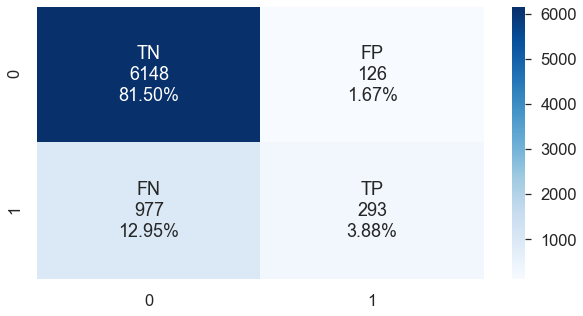

In [330]:
#Train:

train_eval(clf_sgd, X_train_sc, y_train, 'Stochastic Gradient Descent', 'actual')

Classification Report for Test dataset
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      3090
           1       0.74      0.25      0.37       626

    accuracy                           0.86      3716
   macro avg       0.80      0.61      0.65      3716
weighted avg       0.84      0.86      0.83      3716
 

AUC-ROC
0.8280710733376759 

Confusion Matrix


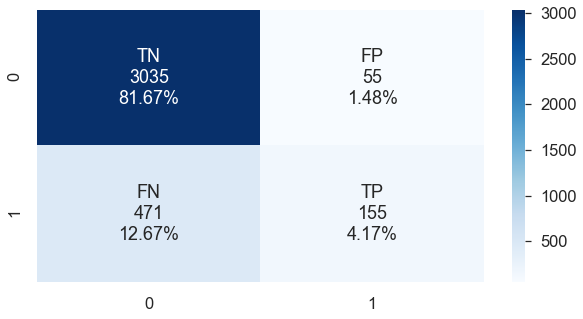

In [331]:
#Test:

test_eval(clf_sgd, X_test_sc, y_test, 'Stochastic Gradient Descent', 'actual')

In [332]:
y_pred = clf_sgd.predict(X_train_sc)
Accuracy_Train =  accuracy_score(y_train, y_pred)
print ('Accuracy_Train', Accuracy_Train)

y_pred = clf_sgd.predict(X_test_sc)
Accuracy_Test =  accuracy_score(y_test, y_pred)
print ('Accuracy_Test', Accuracy_Test)


Accuracy_Train 0.8537910922587487
Accuracy_Test 0.8584499461786868


### Model-4: K-Nearest Neighbours

Definition: Neighbours based classification is a type of lazy learning as it does not attempt to construct a general internal model, but simply stores instances of the training data. Classification is computed from a simple majority vote of the k nearest neighbours of each point.

#### Advantages: 
This algorithm is simple to implement, robust to noisy training data, and effective if training data is large.

#### Disadvantages: 
Need to determine the value of K and the computation cost is high as it needs to compute the distance of each instance to all the training samples.


### 1. Original Unsampled Data

In [333]:
# copy of datasets
X_train_sc = X_train_scaled.copy()
X_test_sc = X_test_scaled.copy()

In [334]:
from sklearn.neighbors import KNeighborsClassifier

clf_knn = KNeighborsClassifier(n_neighbors = 5)
clf_knn.fit(X_train_sc, y_train)


KNeighborsClassifier()

Classification Report for Train dataset
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      6274
           1       0.96      0.86      0.91      1270

    accuracy                           0.97      7544
   macro avg       0.97      0.93      0.95      7544
weighted avg       0.97      0.97      0.97      7544
 

AUC-ROC
0.9932159091764788 

Confusion Matrix


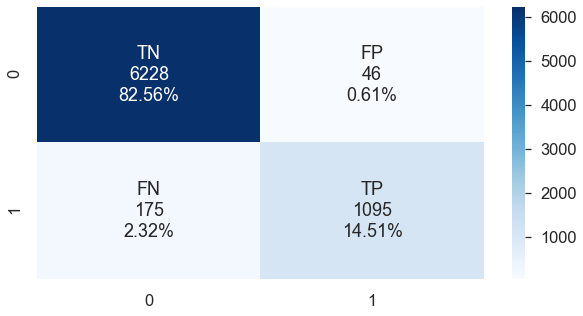

In [335]:
#Train:

train_eval(clf_knn, X_train_sc, y_train, 'K-Nearest Neighbours', 'actual')

Classification Report for Test dataset
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      3090
           1       0.87      0.69      0.77       626

    accuracy                           0.93      3716
   macro avg       0.90      0.83      0.86      3716
weighted avg       0.93      0.93      0.93      3716
 

AUC-ROC
0.9608641707248986 

Confusion Matrix


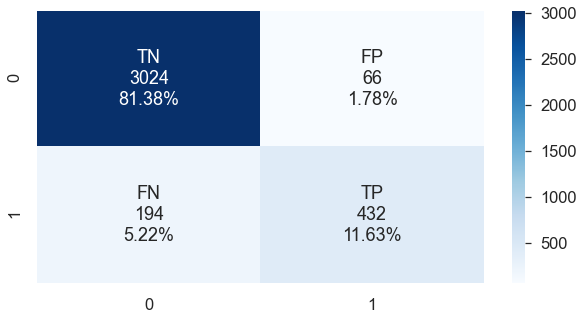

In [336]:
#Test:

test_eval(clf_knn, X_test_sc, y_test, 'K-Nearest Neighbours', 'actual')

In [337]:
y_pred = clf_knn.predict(X_train_sc)
Accuracy_Train =  accuracy_score(y_train, y_pred)
print ('Accuracy_Train', Accuracy_Train)

y_pred = clf_knn.predict(X_test_sc)
Accuracy_Test =  accuracy_score(y_test, y_pred)
print ('Accuracy_Test', Accuracy_Test)


Accuracy_Train 0.9707051961823966
Accuracy_Test 0.930032292787944


### Model-5: Decision Tree

Definition: Given a data of attributes together with its classes, a decision tree produces a sequence of rules that can be used to classify the data.

#### Advantages: 
Decision Tree is simple to understand and visualise, requires little data preparation, and can handle both numerical and categorical data.

#### Disadvantages: 
Decision tree can create complex trees that do not generalise well, and decision trees can be unstable because small variations in the data might result in a completely different tree being generated.


In [338]:
from sklearn.tree import DecisionTreeClassifier

#Number of trees in random forest
estimators = [30,50,100,300,500,1000,1500]

# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']

# Maximum number of depth in each tree:
max_depth = [i for i in range(5,30,2)]

# Minimum number of samples to consider to split a node:
min_samples_split = [2, 5, 10, 15, 20, 50, 100]

# Minimum number of samples to consider at each leaf node:
min_samples_leaf = [5, 4, 7]

### 1. Original Unsampled Data

In [339]:
# copy of datasets
X_train_sc = X_train_scaled.copy()
X_test_sc = X_test_scaled.copy()

In [340]:
tree_model = DecisionTreeClassifier()

tree_param_grid = {'max_depth': max_depth,
                   'max_features':max_features,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf}

cv = StratifiedKFold(n_splits=5)

clf_DT = RandomizedSearchCV(tree_model, tree_param_grid, cv=cv, scoring='recall', random_state=123, n_jobs=-1, verbose=2)
clf_DT.fit(X_train_sc, y_train)
clf_DT.best_estimator_


Fitting 5 folds for each of 10 candidates, totalling 50 fits


DecisionTreeClassifier(max_depth=29, max_features='auto', min_samples_leaf=4,
                       min_samples_split=10)

In [341]:
clf_DT.best_params_

{'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 29}

In [342]:
clf_DT = clf_DT.best_estimator_

Classification Report for Train dataset
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      6274
           1       0.85      0.75      0.80      1270

    accuracy                           0.94      7544
   macro avg       0.90      0.86      0.88      7544
weighted avg       0.93      0.94      0.93      7544
 

AUC-ROC
0.981229621560295 

Confusion Matrix


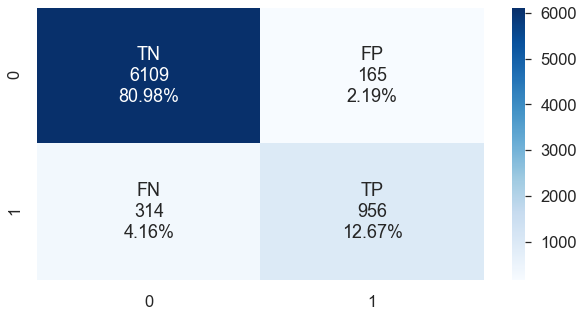

In [343]:
#Train: 

train_eval(clf_DT, X_train_sc, y_train, 'Decision Tree', 'actual')

Classification Report for Test dataset
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      3090
           1       0.68      0.59      0.63       626

    accuracy                           0.88      3716
   macro avg       0.80      0.77      0.78      3716
weighted avg       0.88      0.88      0.88      3716
 

AUC-ROC
0.8598216962891736 

Confusion Matrix


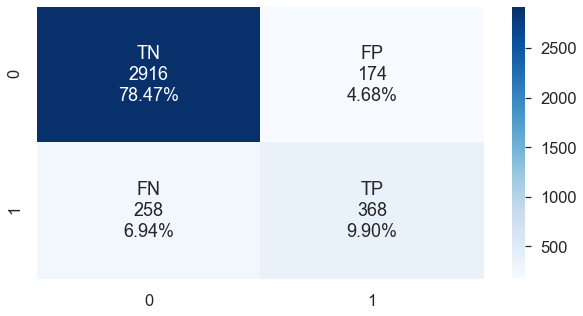

In [344]:
#Test:

test_eval(clf_DT, X_test_sc, y_test, 'Decision Tree', 'actual')

In [345]:
y_pred = clf_DT.predict(X_train_sc)
Accuracy_Train =  accuracy_score(y_train, y_pred)
print ('Accuracy_Train', Accuracy_Train)

y_pred = clf_DT.predict(X_test_sc)
Accuracy_Test =  accuracy_score(y_test, y_pred)
print ('Accuracy_Test', Accuracy_Test)


Accuracy_Train 0.9365058324496288
Accuracy_Test 0.883745963401507


### Model-6: Random Forest

Definition: Random forest classifier is a meta-estimator that fits a number of decision trees on various sub-samples of datasets and uses average to improve the predictive accuracy of the model and controls over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement.

#### Advantages: 
Reduction in over-fitting and random forest classifier is more accurate than decision trees in most cases.

#### Disadvantages: 
Slow real time prediction, difficult to implement, and complex algorithm.

The main parameters used by a Random Forest Classifier are:

- criterion = the function used to evaluate the quality of a split.
- max_depth = maximum number of levels allowed in each tree.
- max_features = maximum number of features considered when splitting a node.
- min_samples_leaf = minimum number of samples which can be stored in a tree leaf.
- min_samples_split = minimum number of samples necessary in a node to cause node splitting.
- n_estimators = number of trees in the ensemble.


### 1. Original Unsampled Data

In [346]:
# copy of datasets
X_train_sc = X_train_scaled.copy()
X_test_sc = X_test_scaled.copy()

In [347]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()

rf_params={'n_estimators':estimators,
           'max_features':max_features,
           'max_depth':max_depth,
           'min_samples_leaf': min_samples_leaf,
           'min_samples_split':min_samples_split}

cv = StratifiedKFold(n_splits=5)

clf_RF = RandomizedSearchCV(rf_model, rf_params, cv=cv, scoring='recall', n_jobs=-1, random_state=123, n_iter=20, verbose=2)
clf_RF.fit(X_train_sc, y_train)
clf_RF.best_estimator_


Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomForestClassifier(max_depth=21, min_samples_leaf=4, n_estimators=1000)

In [348]:
clf_RF = clf_RF.best_estimator_

Classification Report for Train dataset
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      6274
           1       1.00      0.82      0.90      1270

    accuracy                           0.97      7544
   macro avg       0.98      0.91      0.94      7544
weighted avg       0.97      0.97      0.97      7544
 

AUC-ROC
0.9990609916189548 

Confusion Matrix


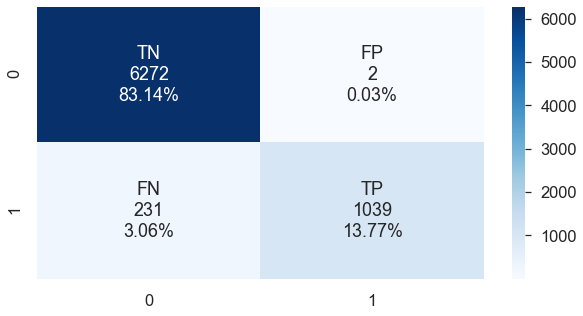

In [349]:
#Train:

train_eval(clf_RF, X_train_sc, y_train, 'Random Forest', 'actual')

Classification Report for Test dataset
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      3090
           1       0.96      0.56      0.70       626

    accuracy                           0.92      3716
   macro avg       0.94      0.78      0.83      3716
weighted avg       0.92      0.92      0.91      3716
 

AUC-ROC
0.9753512826080213 

Confusion Matrix


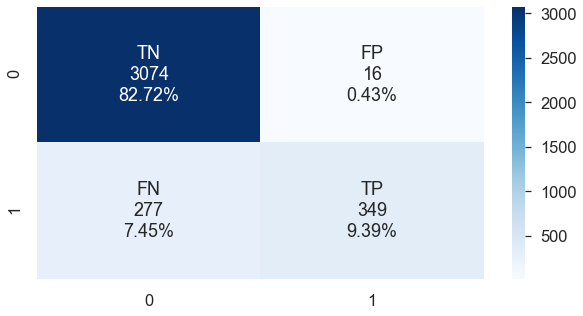

In [350]:
#Test:

test_eval(clf_RF, X_test_sc, y_test, 'Random Forest', 'actual')

In [351]:
y_pred = clf_RF.predict(X_train_sc)
Accuracy_Train =  accuracy_score(y_train, y_pred)
print ('Accuracy_Train', Accuracy_Train)

y_pred = clf_RF.predict(X_test_sc)
Accuracy_Test =  accuracy_score(y_test, y_pred)
print ('Accuracy_Test', Accuracy_Test)

Accuracy_Train 0.9691145281018028
Accuracy_Test 0.9211517761033369


### Model-7: Support Vector Machine

Definition: Support vector machine is a representation of the training data as points in space separated into categories by a clear gap that is as wide as possible. New examples are then mapped into that same space and predicted to belong to a category based on which side of the gap they fall.

#### Advantages: 
Effective in high dimensional spaces and uses a subset of training points in the decision function so it is also memory efficient.
The SVM algorithm has a feature to ignore outliers and find the hyper-plane that has the maximum margin. Hence, we can say, SVM classification is robust to outliers.
The best part is, SVM can also classify non-linear data.

#### Disadvantages: 
The algorithm does not directly provide probability estimates, these are calculated using an expensive five-fold cross-validation.
It doesn’t perform well when we have large data set because the required training time is higher
It also doesn’t perform very well, when the data set has more noise i.e. target classes are overlapping


### 1. Original Unsampled Data

#### Note:

- In SVM, to avoid overfitting, we choose a Soft Margin, instead of a Hard one i.e. we let some data points enter our margin intentionally (but we still penalize it) so that our classifier don’t overfit on our training sample. Here comes an important parameter Gamma (γ), which control Overfitting in SVM. The higher the gamma, the higher the hyperplane tries to match the training data. Therefore, choosing an optimal gamma to avoid Overfitting as well as Underfitting is the key. 
- Linear SVM kernel is used if we have a large number of features (>1000) because it is more likely that the data is linearly separable in high dimensional space. 

In [352]:
# copy of datasets
X_train_sc = X_train_scaled.copy()
X_test_sc = X_test_scaled.copy()

In [353]:
 from sklearn.svm import SVC

svm_model = SVC(probability=True)
clf_svm = SVC(C=0.2, degree=5, gamma='auto', kernel='poly', random_state=123, probability=True)
clf_svm.fit(X_train_sc, y_train)

SVC(C=0.2, degree=5, gamma='auto', kernel='poly', probability=True,
    random_state=123)

Classification Report for Train dataset
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      6274
           1       0.98      0.53      0.69      1270

    accuracy                           0.92      7544
   macro avg       0.95      0.77      0.82      7544
weighted avg       0.93      0.92      0.91      7544
 

AUC-ROC
0.9610206727426523 

Confusion Matrix


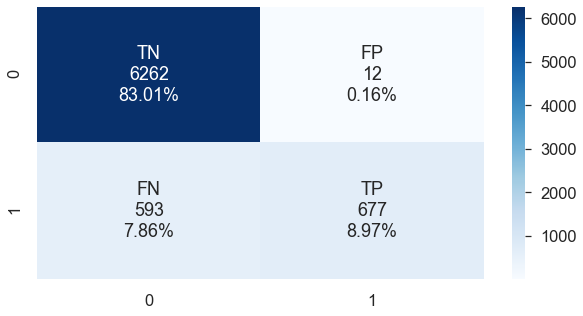

In [354]:
#Train:

train_eval(clf_svm, X_train_sc, y_train,'Support Vector Machine', 'actual')

Classification Report for Test dataset
              precision    recall  f1-score   support

           0       0.90      0.99      0.95      3090
           1       0.93      0.47      0.62       626

    accuracy                           0.90      3716
   macro avg       0.92      0.73      0.79      3716
weighted avg       0.91      0.90      0.89      3716
 

AUC-ROC
0.924991211472647 

Confusion Matrix


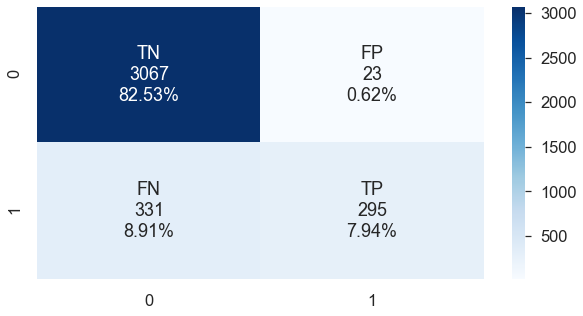

In [355]:
#Test:

test_eval(clf_svm, X_test_sc, y_test, 'Support Vector Machine', 'actual')

In [356]:
y_pred = clf_svm.predict(X_train_sc)
Accuracy_Train =  accuracy_score(y_train, y_pred)
print ('Accuracy_Train', Accuracy_Train)

y_pred = clf_svm.predict(X_test_sc)
Accuracy_Test =  accuracy_score(y_test, y_pred)
print ('Accuracy_Test', Accuracy_Test)

Accuracy_Train 0.9198038176033935
Accuracy_Test 0.9047362755651238


### Model Comparision for imbalanced data

In [357]:
clf_eval_df = pd.DataFrame({'Model':model,
                            'Dataset':dataset,
                            'Resample':resample,
                            'Precision':precision,
                            'Recall':recall,
                            'f1-score':F1score,
                            'Accuracy':Accuracy,
                            'AUC-ROC':AUCROC})

In [358]:
cm = sns.light_palette("green", as_cmap = True)
s = clf_eval_df.style.background_gradient(cmap=cm)
s

,Model,Dataset,Resample,Precision,Recall,f1-score,Accuracy,AUC-ROC
0,Logistic Regression,train,actual,0.367454,0.771654,0.497841,0.737937,0.824815
1,Logistic Regression,test,actual,0.386919,0.784345,0.518206,0.754306,0.840057
2,Naive Bayes,train,actual,0.529691,0.526772,0.528227,0.841596,0.797342
3,Naive Bayes,test,actual,0.538079,0.519169,0.528455,0.843918,0.807516
4,Stochastic Gradient Descent,train,actual,0.699284,0.230709,0.346951,0.853791,0.811238
5,Stochastic Gradient Descent,test,actual,0.738095,0.247604,0.370813,0.858450,0.828071
6,K-Nearest Neighbours,train,actual,0.959684,0.862205,0.908337,0.970705,0.993216
7,K-Nearest Neighbours,test,actual,0.867470,0.690096,0.768683,0.930032,0.960864
8,Decision Tree,train,actual,0.852810,0.752756,0.799665,0.936506,0.981230
9,Decision Tree,test,actual,0.678967,0.587859,0.630137,0.883746,0.859822


#### Inference:

The Churn problem is about client retention, so it is worth to check about False Positives and False Negatives, so precision and recall metrics are a must for this situtation. F1 Score is used to check the quality of the model predictions, as the metric is an harmonic mean of precision and recall.

A comparative analysis was done on the dataset using 7 classifier models:

- Logistic Regression
- Naive Bayes
- Stochastic Gradient Descent
- K-Nearest Neighbours
- Decision Tree
- Random Forest 
- Support Vector Machine. 

From the above, it can be seen on the actual imbalanced dataset, all 7 classifier models were not able to generalize well on the minority class compared to the majority class. As a result, most of the negative class samples were correctly classified. Due to this, there was less FP compared to more FN. After oversampling, a clear surge in Recall is seen on the test data. To understand this better, a comparative barplot is shown below for all 3 models

To compare their performances, as a first step, I applied cross-validation method which is a technique that partitions the data into subsets, training the data on a subset and use the other subset to evaluate the model’s performance. 

For the predictions made by the model and based on the precision and recall scores, as F1 Score try to show a balance between these two metrics, the precision was near 97%, what means that the model predict correctly 97% of classified clients as churned, on other hand, the recall was good, where around 0.74% of the actually churned clients was predict correctly.

The top-performers were 
- Random Forest (0.74 Recall score) 
- Decision Tree (0.60 Recall score). But there is still room for optimization.

The metrics must be used in favor of the business interests, is needed a more correct prediction of the churned clients or get more a part of these clients?

One possible way to improve the results is SMOTE as data resampling.

### SMOTE:

Imbalanced classification involves developing predictive models on classification datasets that have a severe class imbalance.

Generally, the minority/positive class is the class of interest and we aim to achieve the best results in this class rather. If the imbalanced data is not treated beforehand, then this will degrade the performance of the classifier model. Most of the predictions will correspond to the majority class and treat the minority class features as noise in the data and ignore them. This will result in a high bias in the model.

The challenge of working with imbalanced datasets is that most machine learning techniques will ignore, and in turn have poor performance on, the minority class, although typically it is performance on the minority class that is most important.

One approach to addressing imbalanced datasets is to oversample the minority class. The simplest approach involves duplicating examples in the minority class, although these examples don’t add any new information to the model. Instead, new examples can be synthesized from the existing examples. This is a type of data augmentation for the minority class and is referred to as the Synthetic Minority Oversampling Technique, or SMOTE for short.

In [359]:
# copy of datasets
X_train_sc = X_train_scaled.copy()
X_test_sc = X_test_scaled.copy()

In [360]:
from imblearn.over_sampling import SMOTE
from collections import Counter

counter = Counter(y_train)
print('Before',counter)

# oversampling the train dataset using SMOTE
smt = SMOTE(random_state = 123)

#X_train, y_train = smt.fit_resample(X_train, y_train)
X_train_smote, y_train_smote = smt.fit_resample(X_train_sc, y_train.ravel())

counter = Counter(y_train_smote)
print('After',counter)

print('\nAfter OverSampling, the shape of X_train: {}'.format(X_train_smote.shape))
print('After OverSampling, the shape of y_train: {} \n'.format(y_train_smote.shape))

Before Counter({0: 6274, 1: 1270})
After Counter({0: 6274, 1: 6274})

After OverSampling, the shape of X_train: (12548, 17)
After OverSampling, the shape of y_train: (12548,) 



#### Note:
The SMOTE and its related techniques are only applied to the training dataset so that we fit our algorithm properly on the data. The test data remains unchanged so that it correctly represents the original data.

### Model Building - Balanced data

In [361]:
# copy of datasets
X_train_sm = X_train_smote.copy()
y_train_sm = y_train_smote.copy()

In [362]:
model = list()
dataset = list()
resample = list()
precision = list()
recall = list()
F1score = list()
Accuracy = list()
AUCROC = list()

In [363]:
def train_eval(clf_model, X_train_sm, y_train_sm, algo=None, sampling=None):
    
    # Test set prediction
    y_prob=clf_model.predict_proba(X_train_sm)
    y_pred=clf_model.predict(X_train_sm)

    print('Classification Report for Train dataset')
    print('='*60)
    print(classification_report(y_train_sm,y_pred),"\n")
    print('AUC-ROC')
    print('='*60)
    print(roc_auc_score(y_train_sm, y_prob[:,1]),"\n")
    
    print('Confusion Matrix')
    print('='*60)
    cf_matrix = confusion_matrix(y_train_sm, y_pred)
    group_names = ['TN','FP','FN','TP']
    group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
          
    model.append(algo)
    precision.append(precision_score(y_train_sm,y_pred))
    recall.append(recall_score(y_train_sm,y_pred))
    F1score.append(f1_score(y_train_sm,y_pred))
    Accuracy.append(accuracy_score(y_train_sm, y_pred))
    AUCROC.append(roc_auc_score(y_train_sm, y_prob[:,1]))
    dataset.append('train')
    resample.append(sampling)
   

In [364]:
def test_eval(clf_model, X_test_scaled, y_test, algo=None, sampling=None):
    
    # Test set prediction
    y_prob=clf_model.predict_proba(X_test_scaled)
    y_pred=clf_model.predict(X_test_scaled)

    
    print('Classification Report for Test dataset')
    print('='*60)
    print(classification_report(y_test,y_pred),"\n")
    print('AUC-ROC')
    print('='*60)
    print(roc_auc_score(y_test, y_prob[:,1]),"\n")
    
    print('Confusion Matrix')
    print('='*60)
    cf_matrix = confusion_matrix(y_test, y_pred)
    group_names = ['TN','FP','FN','TP']
    group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
          
    model.append(algo)
    precision.append(precision_score(y_test,y_pred))
    recall.append(recall_score(y_test,y_pred))
    F1score.append(f1_score(y_test,y_pred))
    Accuracy.append(accuracy_score(y_test, y_pred))
    AUCROC.append(roc_auc_score(y_test, y_prob[:,1]))
    dataset.append('test')
    resample.append(sampling)

### Model-1: Logistic Regression - SMOTE Resampling

In [365]:
# copy of datasets
X_train_sm = X_train_smote.copy()
y_train_sm = y_train_smote.copy()

In [366]:
# oversampling the train dataset using SMOTE
smt = SMOTE(random_state = 123)

#X_train, y_train = smt.fit_resample(X_train, y_train)
X_train_sm, y_train_sm = smt.fit_resample(X_train_scaled, y_train.ravel())

In [367]:
log_model=LogisticRegression()

params={'C':np.logspace(1,10),'class_weight':[None,'balanced'],'penalty':['l1','l2']}

cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

# Create grid search using 5-fold cross validation
clf_LR_sm = GridSearchCV(log_model, params, cv=cv, scoring='recall', n_jobs=-1)
clf_LR_sm.fit(X_train_sm, y_train_sm)
clf_LR_sm.best_estimator_

LogisticRegression(C=10.0)

Classification Report for Train dataset
              precision    recall  f1-score   support

           0       0.77      0.74      0.75      6274
           1       0.75      0.78      0.77      6274

    accuracy                           0.76     12548
   macro avg       0.76      0.76      0.76     12548
weighted avg       0.76      0.76      0.76     12548
 

AUC-ROC
0.8330299695074643 

Confusion Matrix


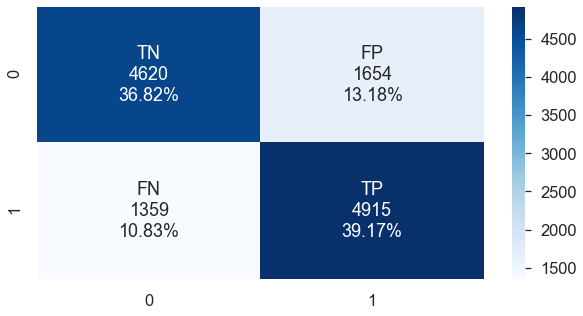

In [368]:
# Train:

train_eval(clf_LR_sm, X_train_sm, y_train_sm, 'Logistic Regression', 'smote')

Classification Report for Test dataset
              precision    recall  f1-score   support

           0       0.94      0.75      0.84      3090
           1       0.39      0.78      0.52       626

    accuracy                           0.76      3716
   macro avg       0.67      0.76      0.68      3716
weighted avg       0.85      0.76      0.78      3716
 

AUC-ROC
0.840352264855196 

Confusion Matrix


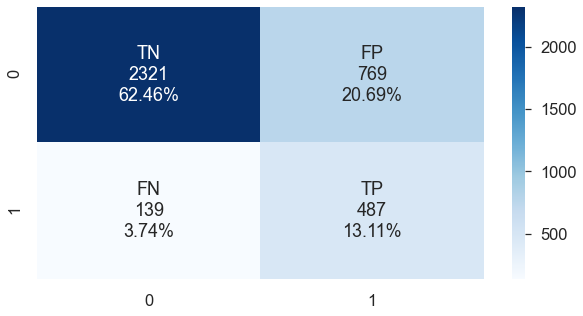

In [369]:
#Test:

test_eval(clf_LR_sm, X_test_scaled, y_test, 'Logistic Regression', 'smote')

In [370]:
y_pred = clf_LR_sm.predict(X_train_sm)
Accuracy_Train =  accuracy_score(y_train_sm, y_pred)
print ('Accuracy_Train', Accuracy_Train)

y_pred = clf_LR_sm.predict(X_test_scaled)
Accuracy_Test =  accuracy_score(y_test, y_pred)
print ('Accuracy_Test', Accuracy_Test)


Accuracy_Train 0.7598820529167994
Accuracy_Test 0.7556512378902045


### Model-2: Naïve Bayes - SMOTE Resampling

In [371]:
# copy of datasets
X_train_sm = X_train_smote.copy()
y_train_sm = y_train_smote.copy()

In [372]:
clf_nb.fit(X_train_sm, y_train_sm)

GaussianNB()

Classification Report for Train dataset
              precision    recall  f1-score   support

           0       0.74      0.57      0.64      6274
           1       0.65      0.80      0.72      6274

    accuracy                           0.68     12548
   macro avg       0.70      0.68      0.68     12548
weighted avg       0.70      0.68      0.68     12548
 

AUC-ROC
0.8007458817496884 

Confusion Matrix


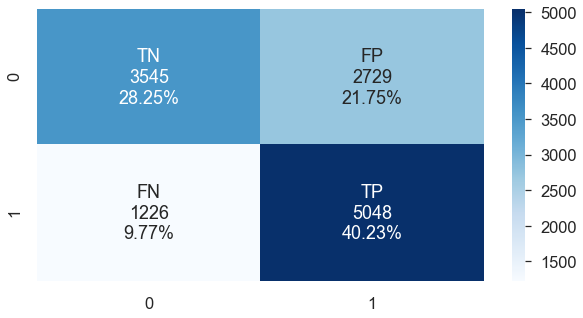

In [373]:
# Train:

train_eval(clf_nb, X_train_sm, y_train_sm, 'Naive Bayes', 'smote')

Classification Report for Test dataset
              precision    recall  f1-score   support

           0       0.94      0.60      0.73      3090
           1       0.29      0.80      0.42       626

    accuracy                           0.64      3716
   macro avg       0.61      0.70      0.58      3716
weighted avg       0.83      0.64      0.68      3716
 

AUC-ROC
0.801571078507398 

Confusion Matrix


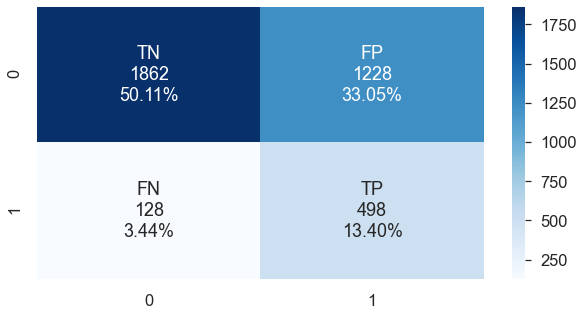

In [374]:
#Test:

test_eval(clf_nb, X_test_scaled, y_test, 'Naive Bayes', 'smote')

In [375]:
y_pred = clf_nb.predict(X_train_sm)
Accuracy_Train =  accuracy_score(y_train_sm, y_pred)
print ('Accuracy_Train', Accuracy_Train)

y_pred = clf_nb.predict(X_test_scaled)
Accuracy_Test =  accuracy_score(y_test, y_pred)
print ('Accuracy_Test', Accuracy_Test)

Accuracy_Train 0.6848103283391775
Accuracy_Test 0.635091496232508


### Model-3: Stochastic Gradient Descent - SMOTE Resampling

In [376]:
# copy of smote datasets
X_train_sm = X_train_smote.copy()
y_train_sm = y_train_smote.copy()

In [377]:
clf_sgd.fit(X_train_sm, y_train_sm)

SGDClassifier(loss='log', max_iter=1500, random_state=123)

Classification Report for Train dataset
              precision    recall  f1-score   support

           0       0.72      0.81      0.76      6274
           1       0.78      0.68      0.73      6274

    accuracy                           0.75     12548
   macro avg       0.75      0.75      0.74     12548
weighted avg       0.75      0.75      0.74     12548
 

AUC-ROC
0.8254741067491779 

Confusion Matrix


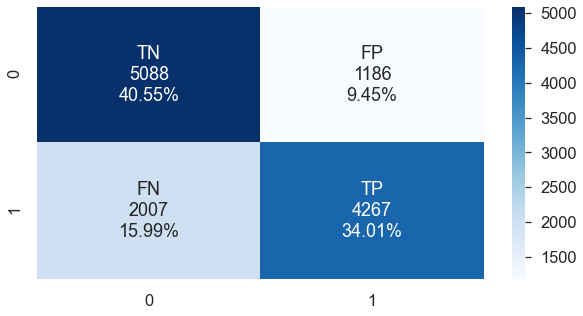

In [378]:
#Train:

train_eval(clf_sgd, X_train_sm, y_train_sm, 'Stochastic Gradient Descent', 'smote')

Classification Report for Test dataset
              precision    recall  f1-score   support

           0       0.93      0.81      0.87      3090
           1       0.42      0.68      0.52       626

    accuracy                           0.79      3716
   macro avg       0.68      0.75      0.69      3716
weighted avg       0.84      0.79      0.81      3716
 

AUC-ROC
0.8297589875616489 

Confusion Matrix


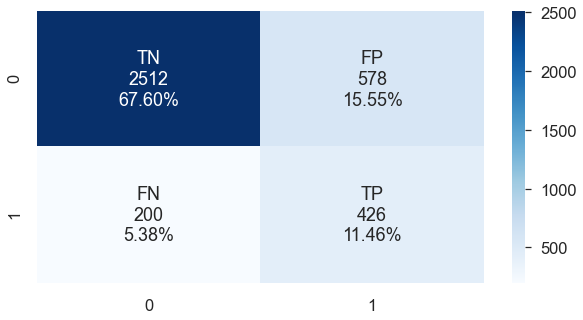

In [379]:
#Test:

test_eval(clf_sgd, X_test_scaled, y_test, 'Stochastic Gradient Descent', 'smote')

In [380]:
y_pred = clf_sgd.predict(X_train_sm)
Accuracy_Train =  accuracy_score(y_train_sm, y_pred)
print ('Accuracy_Train', Accuracy_Train)

y_pred = clf_sgd.predict(X_test_scaled)
Accuracy_Test =  accuracy_score(y_test, y_pred)
print ('Accuracy_Test', Accuracy_Test)

Accuracy_Train 0.7455371373924131
Accuracy_Test 0.7906350914962325


### Model-4: K-Nearest Neighbours - SMOTE Resampling

In [381]:
# copy of datasets
X_train_sm = X_train_smote.copy()
y_train_sm = y_train_smote.copy()

In [382]:
clf_knn.fit(X_train_sm, y_train_sm)

KNeighborsClassifier()

Classification Report for Train dataset
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      6274
           1       0.95      1.00      0.97      6274

    accuracy                           0.97     12548
   macro avg       0.98      0.97      0.97     12548
weighted avg       0.98      0.97      0.97     12548
 

AUC-ROC
0.9998555117999417 

Confusion Matrix


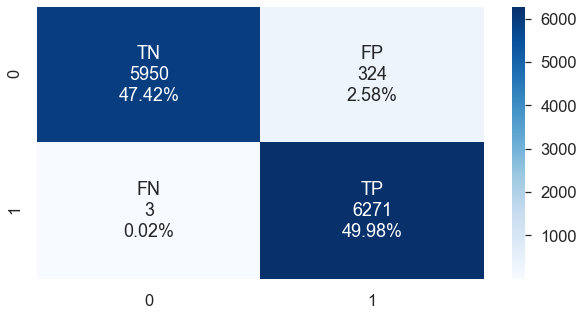

In [383]:
#Train:

train_eval(clf_knn, X_train_sm, y_train_sm, 'K-Nearest Neighbours', 'smote')

Classification Report for Test dataset
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      3090
           1       0.66      0.96      0.78       626

    accuracy                           0.91      3716
   macro avg       0.83      0.93      0.86      3716
weighted avg       0.94      0.91      0.92      3716
 

AUC-ROC
0.9764170207926218 

Confusion Matrix


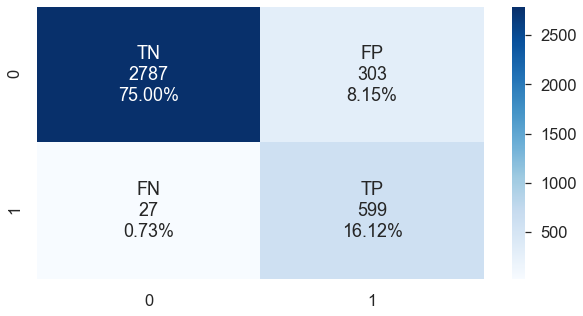

In [384]:
#Test:

test_eval(clf_knn, X_test_scaled, y_test, 'K-Nearest Neighbours', 'smote')

In [385]:
y_pred = clf_knn.predict(X_train_sm)
Accuracy_Train =  accuracy_score(y_train_sm, y_pred)
print ('Accuracy_Train', Accuracy_Train)

y_pred = clf_knn.predict(X_test_scaled)
Accuracy_Test =  accuracy_score(y_test, y_pred)
print ('Accuracy_Test', Accuracy_Test)

Accuracy_Train 0.9739400701306982
Accuracy_Test 0.9111948331539289


### Model-5: Decision Tree - SMOTE Resampling

In [386]:
# copy of datasets
X_train_sm = X_train_smote.copy()
y_train_sm = y_train_smote.copy()

In [387]:
clf_DT.fit(X_train_sm, y_train_sm)

DecisionTreeClassifier(max_depth=29, max_features='auto', min_samples_leaf=4,
                       min_samples_split=10)

Classification Report for Train dataset
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      6274
           1       0.96      0.95      0.95      6274

    accuracy                           0.95     12548
   macro avg       0.96      0.95      0.95     12548
weighted avg       0.96      0.95      0.95     12548
 

AUC-ROC
0.9946341083710023 

Confusion Matrix


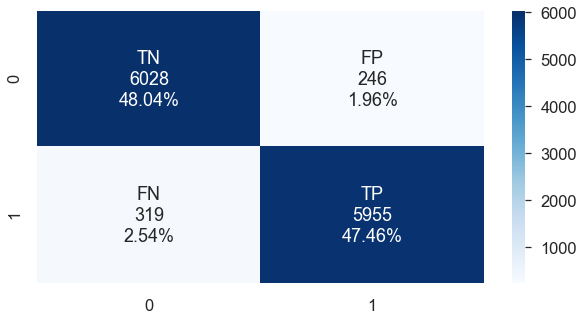

In [388]:
#Train:
train_eval(clf_DT, X_train_sm, y_train_sm, 'Decision Tree', 'smote')

Classification Report for Test dataset
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      3090
           1       0.62      0.69      0.66       626

    accuracy                           0.88      3716
   macro avg       0.78      0.80      0.79      3716
weighted avg       0.88      0.88      0.88      3716
 

AUC-ROC
0.882850222815017 

Confusion Matrix


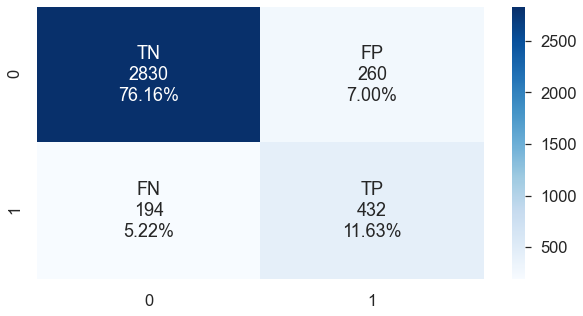

In [389]:
#Test:
test_eval(clf_DT, X_test_scaled, y_test, 'Decision Tree', 'smote')

In [390]:
y_pred = clf_DT.predict(X_train_sm)
Accuracy_Train =  accuracy_score(y_train_sm, y_pred)
print ('Accuracy_Train', Accuracy_Train)

y_pred = clf_DT.predict(X_test_scaled)
Accuracy_Test =  accuracy_score(y_test, y_pred)
print ('Accuracy_Test', Accuracy_Test)

Accuracy_Train 0.9549729040484539
Accuracy_Test 0.8778256189451022


### a. Ensemble modelling (if necessary)

### Model-6: Random Forest - SMOTE Resampling

In [391]:
# copy of datasets
X_train_sm = X_train_smote.copy()
y_train_sm = y_train_smote.copy()

In [392]:
#clf_RF = RandomForestClassifier(max_depth=23, max_features='log2', min_samples_leaf=4, min_samples_split=5, n_estimators=500)  
#clf_RF = RandomForestClassifier(max_depth=40, max_features='log2', min_samples_leaf=5, min_samples_split=6, n_estimators=2000)

In [393]:
clf_RF.fit(X_train_sm, y_train_sm)

RandomForestClassifier(max_depth=21, min_samples_leaf=4, n_estimators=1000)

Classification Report for Train dataset
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6274
           1       1.00      0.99      0.99      6274

    accuracy                           0.99     12548
   macro avg       0.99      0.99      0.99     12548
weighted avg       0.99      0.99      0.99     12548
 

AUC-ROC
0.9998241245170982 

Confusion Matrix


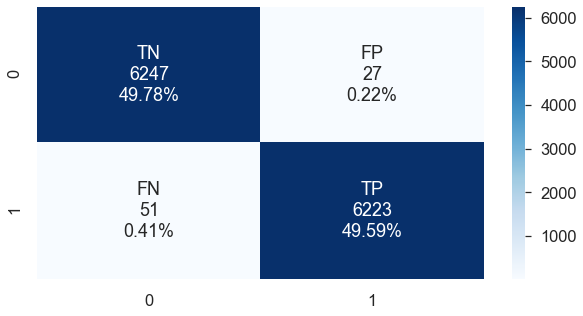

In [394]:
#Train:
train_eval(clf_RF, X_train_sm, y_train_sm, 'Random Forest', 'smote')

Classification Report for Test dataset
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      3090
           1       0.84      0.75      0.79       626

    accuracy                           0.93      3716
   macro avg       0.90      0.86      0.88      3716
weighted avg       0.93      0.93      0.93      3716
 

AUC-ROC
0.9728755027554619 

Confusion Matrix


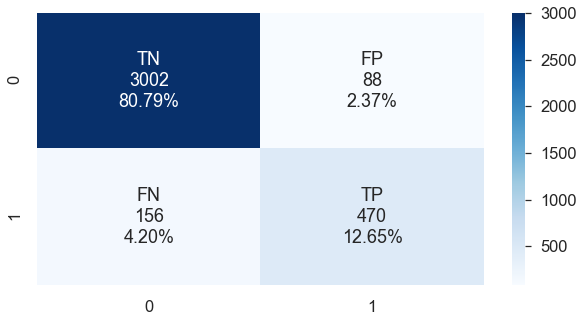

In [395]:
#Test:
test_eval(clf_RF, X_test_scaled, y_test, 'Random Forest', 'smote')

In [396]:
y_pred = clf_RF.predict(X_train_sm)
Accuracy_Train =  accuracy_score(y_train_sm, y_pred)
print ('Accuracy_Train', Accuracy_Train)

y_pred = clf_RF.predict(X_test_scaled)
Accuracy_Test =  accuracy_score(y_test, y_pred)
print ('Accuracy_Test', Accuracy_Test)


Accuracy_Train 0.9937838699394326
Accuracy_Test 0.9343379978471474


### Model-7: Support Vector Machine

In [397]:
# copy of datasets
X_train_sm = X_train_smote.copy()
y_train_sm = y_train_smote.copy()

In [398]:
clf_svm.fit(X_train_sm, y_train_sm)

SVC(C=0.2, degree=5, gamma='auto', kernel='poly', probability=True,
    random_state=123)

Classification Report for Train dataset
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      6274
           1       0.93      0.97      0.95      6274

    accuracy                           0.95     12548
   macro avg       0.95      0.95      0.95     12548
weighted avg       0.95      0.95      0.95     12548
 

AUC-ROC
0.9864007579082488 

Confusion Matrix


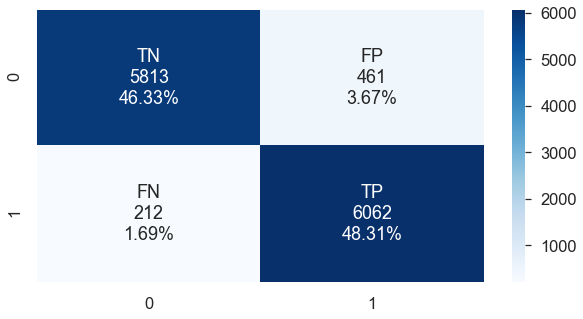

In [399]:
#Train:
train_eval(clf_svm, X_train_sm, y_train_sm, 'Support Vector Machine', 'smote')

Classification Report for Test dataset
              precision    recall  f1-score   support

           0       0.97      0.92      0.94      3090
           1       0.68      0.85      0.75       626

    accuracy                           0.91      3716
   macro avg       0.82      0.88      0.85      3716
weighted avg       0.92      0.91      0.91      3716
 

AUC-ROC
0.9484382269921524 

Confusion Matrix


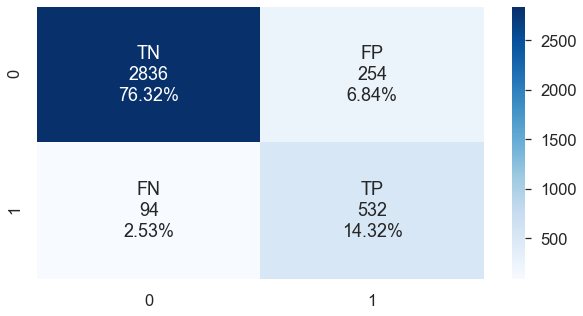

In [400]:
#Test:
test_eval(clf_svm, X_test_scaled, y_test, 'Support Vector Machine', 'smote')

In [401]:
y_pred = clf_svm.predict(X_train_sm)
Accuracy_Train =  accuracy_score(y_train_sm, y_pred)
print ('Accuracy_Train', Accuracy_Train)

y_pred = clf_svm.predict(X_test_scaled)
Accuracy_Test =  accuracy_score(y_test, y_pred)
print ('Accuracy_Test', Accuracy_Test)


Accuracy_Train 0.9463659547338221
Accuracy_Test 0.9063509149623251


### Model Comparison for balanced data

In [402]:
clf_eval_df2 = pd.DataFrame({'Model':model,
                            'Dataset':dataset,
                            'Resample':resample,
                            'Precision':precision,
                            'Recall':recall,
                            'f1-score':F1score,
                            'Accuracy':Accuracy,
                            'AUC-ROC':AUCROC})

In [403]:
cm = sns.light_palette("green", as_cmap = True)
s = clf_eval_df2.style.background_gradient(cmap=cm)
s

,Model,Dataset,Resample,Precision,Recall,f1-score,Accuracy,AUC-ROC
0,Logistic Regression,train,smote,0.748211,0.783392,0.765397,0.759882,0.833030
1,Logistic Regression,test,smote,0.387739,0.777955,0.517535,0.755651,0.840352
2,Naive Bayes,train,smote,0.649093,0.804590,0.718525,0.684810,0.800746
3,Naive Bayes,test,smote,0.288528,0.795527,0.423469,0.635091,0.801571
4,Stochastic Gradient Descent,train,smote,0.782505,0.680108,0.727722,0.745537,0.825474
5,Stochastic Gradient Descent,test,smote,0.424303,0.680511,0.522699,0.790635,0.829759
6,K-Nearest Neighbours,train,smote,0.950872,0.999522,0.974590,0.973940,0.999856
7,K-Nearest Neighbours,test,smote,0.664080,0.956869,0.784031,0.911195,0.976417
8,Decision Tree,train,smote,0.960329,0.949155,0.954709,0.954973,0.994634
9,Decision Tree,test,smote,0.624277,0.690096,0.655539,0.877826,0.882850


### c. Interpretation of the model(s)

### Inference:

As discussed earlier, we’ll ignore the accuracy metric to evaluate the performance of the classifier on this imbalanced dataset. Here, we are more interested to know that which are the customers who’ll churn out in the coming months. Thereby, we’ll focus on metrics like precision, recall, F1-score to understand the performance of the classifiers for correctly determining which customers will churn.

### Ensembling
Ensembles are machine learning methods for combining predictions from multiple separate models. There are a few different methods for ensembling, but the two most common are:

- Bagging attempts to reduce the chance overfitting complex models.

It trains a large number of "strong" learners in parallel.
A strong learner is a model that's relatively unconstrained.
Bagging then combines all the strong learners together in order to "smooth out" their predictions.

- Boosting attempts to improve the predictive flexibility of simple models.

It trains a large number of "weak" learners in sequence.
A weak learner is a constrained model (i.e. you could limit the max depth of each decision tree).
Each one in the sequence focuses on learning from the mistakes of the one before it.
Boosting then combines all the weak learners into a single strong learner.
While bagging and boosting are both ensemble methods, they approach the problem from opposite directions.

Bagging uses complex base models and tries to "smooth out" their predictions, while boosting uses simple base models and tries to "boost" their aggregate complexity.

### Bagging

In [193]:
from sklearn.ensemble import BaggingClassifier

Bagging_model=BaggingClassifier(base_estimator=clf_RF,n_estimators=200,random_state=123)
Bagging_model.fit(X_train_sm, y_train_sm)

BaggingClassifier(base_estimator=RandomForestClassifier(max_depth=21,
                                                        min_samples_leaf=4,
                                                        n_estimators=1000),
                  n_estimators=200, random_state=123)

Classification Report for Train dataset
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      6274
           1       0.98      0.98      0.98      6274

    accuracy                           0.98     12548
   macro avg       0.98      0.98      0.98     12548
weighted avg       0.98      0.98      0.98     12548
 

AUC-ROC
0.9988553994103511 

Confusion Matrix


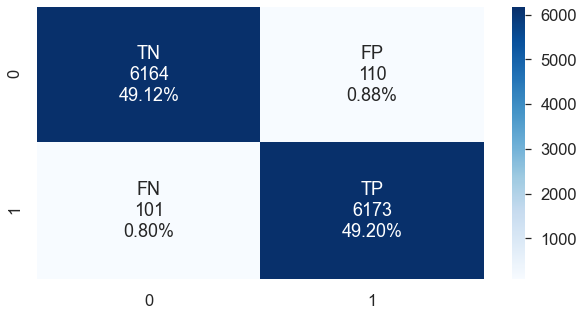

In [404]:
#Train:

train_eval(Bagging_model, X_train_sm, y_train_sm, 'Bagging Classifier', 'smote')

Classification Report for Test dataset
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      3090
           1       0.47      0.57      0.51       626

    accuracy                           0.82      3716
   macro avg       0.69      0.72      0.70      3716
weighted avg       0.83      0.82      0.83      3716
 

AUC-ROC
0.8138375363172967 

Confusion Matrix


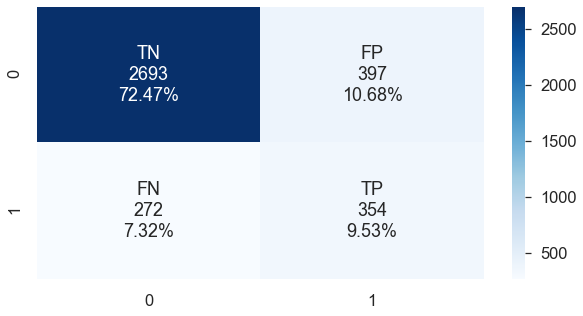

In [405]:
#Test:

test_eval(Bagging_model, X_test, y_test, 'Bagging Classifier', 'smote')

In [406]:
y_pred = Bagging_model.predict(X_train)
Accuracy_Train =  accuracy_score(y_train, y_pred)
print ('Accuracy_Train', Accuracy_Train)

y_pred = Bagging_model.predict(X_test)
Accuracy_Test =  accuracy_score(y_test, y_pred)
print ('Accuracy_Test', Accuracy_Test)


Accuracy_Train 0.8095174973488866
Accuracy_Test 0.819967707212056


### c. Interpretation of the most optimum model and its implication on the business

###  Interpretation:

- In this project, I have tried to divide customer churn prediction problem into steps like exploration, profiling, clustering, model selection & evaluation and retention plans. Based on this analysis, we can help retention team to analyse high risk churn customers before they leave the company.
- Moreover, we can aggregate different data sources like customer inquiries, seasonality in sales, more demographic information to make our prediction more accurate.
- From the results and explanations presented here, some conclusion can be draw:
- The type account segment has a strict relationship with churned clients, Low Tenure with high complaints could lead a client to leave the service. Clients with a greater number of account_user_count tend to leave.

We can now see that the main factors are.
1.	Customer Demography:
Tenure
- Longtime customers are less likely to leave the company.
- Loyalty
- Can the company make contracts of 3-4yrs more attractive?
Gender
- Male customers tend to churn more.
- Attrack them with some sports, games, and discovery type channels combo packages.
2.	Customer record analysis:
Account_segment
- People having Regular Plus are more likely to leave.
- Is there something wrong with the Regular Plus segment?
3.	Customer care service analysis:
Complain_ly
- People having more complaints are more likely to leave.
- Are customers unhappy with the solution given by customer service.
Service score
- Low score given by customers tend to churn.
- Resolve their problems by giving them good offers like cashback or free channels for one month.

### Business Implications:

- Depending on the re-engagement campaign, it can be a good trade-off to target the highest possible number of customers at risk to churn, and in parallel unintentionally reach some happy customers, than to leave a high number of customers to cancel without taking proper actions.

### Conclusion: 

- No algorithm will predict churn with 100% accuracy. There will always be a trade-off between precision and recall. That is why it is important to test and understand the strengths and weaknesses of each classifier and get the best out of each. If the goal is to engage and reach out to the customers to prevent them from churning, it is acceptable to engage with those who are mistakenly tagged as ‘not churned,’ as it does not cause any negative impact. It could potentially make them even happier with the service. This is the kind of model that can add value from day one if proper action is taken out of meaningful information it produces.

END


#### 